# Protein conformational space exploration (CSE) using basins trajectories and a Variational Autoencoder

**Packages required:**
    
* MDAnalysis
* MDAnalysisData
* matplotlib
* numpy
* sklearn
* tensorflow
* Bio
* nglview
* pytraj

In [1]:
import warnings
# avoid excessive warning messages to make the notebook nicer
warnings.filterwarnings('ignore')
# warnings.filterwarnings("ignore", category=DeprecationWarning)
# warnings.filterwarnings("ignore", category=UserWarning)
# warnings.filterwarnings("ignore", category=RuntimeWarning)

In [2]:
import os
import subprocess
import random
import MDAnalysis as mda
from MDAnalysis.tests.datafiles import GRO, XTC
from MDAnalysis.analysis import dihedrals, rms, align
import MDAnalysisData as mda_data
from MDAnalysisData import datasets
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from numpy import savetxt,loadtxt
import sklearn as skl
from sklearn import cluster, mixture
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from sklearn.cluster import KMeans
import tensorflow as tf
from tensorflow import keras 
from tensorflow.keras import layers, Sequential
from tensorflow.keras.layers import Layer,Dropout,Dense,Bidirectional
from tensorflow.keras.layers import GRU,LSTM,Embedding,MultiHeadAttention
from tensorflow.keras.layers import LayerNormalization,Conv1D
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model, model_from_json, load_model, clone_model
from tensorflow.python.client import device_lib
import nglview as nv
import Bio as bio
from Bio.SeqUtils import seq1, seq3
from itertools import chain, islice
import pytraj as pt
import h5py

import modeller as modl
from modeller import *
from modeller.automodel import *    # Load the AutoModel class
from modeller.scripts import complete_pdb
from modeller.optimizers import conjugate_gradients, molecular_dynamics, actions

print("mda version = {}".format(mda.__version__))
print("mda data version = {}".format(mda_data.__version__))
print("plt version = {}".format(matplotlib.__version__))
print("np version = {}".format(np.__version__))
print("skl version = {}".format(skl.__version__))
print("tf version = {}".format(tf.__version__))
print("bio version = {}".format(bio.__version__))
print("nglview version = {}".format(nv.__version__))
print("pytraj version = {}".format(pt.__version__))
print("modeller version = {}\n".format(modl.__version__))

%matplotlib inline
%load_ext autoreload
%autoreload 2

/Users/dgatti/opt/anaconda3/envs/ana_md/lib/python3.9/site-packages/MDAnalysis/coordinates/chemfiles.py:108: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  MIN_CHEMFILES_VERSION = LooseVersion("0.9")
/Users/dgatti/opt/anaconda3/envs/ana_md/lib/python3.9/site-packages/MDAnalysis/coordinates/TRJ.py:1209: DeprecationWarning: Please use `netcdf_file` from the `scipy.io` namespace, the `scipy.io.netcdf` namespace is deprecated.
  class NCDFPicklable(scipy.io.netcdf.netcdf_file):


mda version = 2.0.0
mda data version = 0.8.1
plt version = 3.5.1
np version = 1.22.2
skl version = 1.0.2
tf version = 2.8.0
bio version = 1.78
nglview version = 3.0.3
pytraj version = 2.0.6
modeller version = 10.2



## Loading files

### Equilibrium adk trajectory

The file we work with here features adenylate kinase (AdK), a small protein of 214 residues. This is a long MD trajectory with 4187 frames covering over 1 $\mu s$. We will ignore solvent molecules. The variable 'protein' contains all the protein atoms in the MD.

In [3]:
# adk = datasets.fetch_adk_equilibrium()

# print(adk.DESCR)
# print(adk.topology)
# print(adk.trajectory)

In [4]:
# u_equil = mda.Universe(adk.topology, adk.trajectory)

# n_frames = len(u_equil.trajectory)
# print(f'There are {n_frames} frames in the trajectory')

# # Atom selection
# protein = u_equil.select_atoms('protein')
# print(f'There are {len(protein.residues)} protein residues in each frame')

### Multiple adk transition trajectories 

The file we work with here also feature adenylate kinase (AdK), but it is an ensemble of shorter trajectories, each containing a conformational transition. 

In [5]:
adk_trans = datasets.fetch_adk_transitions_DIMS()

print(adk_trans.DESCR)
print(adk_trans.topology) 

.. -*- coding: utf-8 -*-

.. _`adk-transitions-DIMS-dataset`:

AdK DIMS transitions ensemble dataset

The macromolecular conformational transition between the closed
conformation of apo-adenylate kinase from E. coli (EcAdK) to the open
conformation was sampled with two methods: (1) dynamic importance
sampling molecular dynamics (DIMS MD) [Perilla2009]_, and (2)
Framework Rigidity Optimized Dynamics Algorithm (FRODA)
[Farrell2010]_. Each ensemble of independently generated paths
contains 200 trajectories in the CHARMM DCD format.

This data set contains the **DIMS** ensemble.

DIMS AdK (implicit solvent) with dynamic importance sampling MD from
closed (1AKE) to open (4AKE). CHARMM 22 force field. Topology file:
adk4ake.psf


Notes
-----

Data set characteristics:

 :size: 757 MB
 :number of trajectories:  200	
 :number of frames:  varies
 :number of atoms: 3341
 :creator: Sean L. Seyler
 :URL:  `https://doi.org/10.6084/m9.figshare.7165306.v2 <https://doi.org/10.6084/m9.figshare.7165306.

In [6]:
# Here we examine the entire ensemble of trajectories. Later on we will use the 
# variable 'all_trj_nframes' to train recursively the VAE with all the trajectories
# in the ensemble
n_trj = len(adk_trans.trajectories)
all_trj_nframes = []

for i,trajectory in enumerate(adk_trans.trajectories):
    u = mda.Universe(adk_trans.topology, trajectory)
    single_trj_nframes = len(u.trajectory)
    all_trj_nframes.append(single_trj_nframes)

all_trj_nframes = np.array(all_trj_nframes)

print(f'Number of trajectories in the ensemble: {n_trj}')
print(f'Number of frames in each trajectory of the ensemble:')
print(*all_trj_nframes,'\n')

Number of trajectories in the ensemble: 200
Number of frames in each trajectory of the ensemble:
97 97 98 95 100 98 97 97 96 99 96 97 98 97 107 96 99 100 99 100 99 97 96 98 98 95 98 97 100 99 98 100 100 102 102 94 97 96 102 99 98 96 100 100 99 100 100 103 96 100 101 100 101 100 99 103 103 101 93 105 95 100 103 102 103 101 98 96 101 99 95 96 98 97 94 100 102 98 102 97 99 98 96 96 97 100 95 99 92 93 101 97 93 98 96 103 92 100 96 103 98 100 91 96 98 94 97 102 98 102 100 94 94 96 94 98 101 101 102 100 100 98 104 96 94 99 101 101 97 95 101 96 97 95 102 98 99 102 94 98 96 98 98 100 101 98 95 99 100 97 100 99 93 98 98 97 96 97 100 103 106 99 98 102 105 101 99 98 100 93 101 103 101 96 95 98 98 100 99 102 99 92 94 98 102 96 101 98 101 100 96 97 96 97 99 98 102 102 94 100 



### Validation, Test, and All sets

In [7]:
# Here we select the first two trajectories of the ensemble as the validation and test sets, respectively. 
# Later on we will loop through the other trajectories to train the NN.
u_val = mda.Universe(adk_trans.topology, adk_trans.trajectories[0])
u_test = mda.Universe(adk_trans.topology, adk_trans.trajectories[1])
u_all = mda.Universe(adk_trans.topology, adk_trans.trajectories)
print(f'Number of frames in the validation set: {len(u_val.trajectory)}')
print(f'Number of frames in the test set: {len(u_test.trajectory)}')
print(f'Number of frames in all sets: {len(u_all.trajectory)}')

Number of frames in the validation set: 97
Number of frames in the test set: 97
Number of frames in all sets: 19691


In [8]:
# Here we view the conformational transition of the validation trajectory 
view = nv.show_mdanalysis(u_val)
view.center()
view

NGLWidget(max_frame=96)

In [9]:
# Here we process the validation set
n_val_frames = len(u_val.trajectory)
print(f'There are {n_val_frames} frames in the validation trajectory')
val_protein = u_val.select_atoms('protein')
print(f'There are {len(val_protein.residues)} protein residues in each frame')

# Here we process the test set
n_test_frames = len(u_test.trajectory)
print(f'There are {n_test_frames} frames in the test trajectory')
test_protein = u_test.select_atoms('protein')
print(f'There are {len(test_protein.residues)} protein residues in each frame')

# Here we process all the trajectories of the ensemble  
n_all_frames = len(u_all.trajectory)
print(f'There are {n_all_frames} frames in the set of all trajectories')
all_protein = u_all.select_atoms('protein')
print(f'There are {len(all_protein.residues)} protein residues in each frame')


There are 97 frames in the validation trajectory
There are 214 protein residues in each frame
There are 97 frames in the test trajectory
There are 214 protein residues in each frame
There are 19691 frames in the set of all trajectories
There are 214 protein residues in each frame


## Ramachandran analysis

The `Ramachandran` class calculates the $\phi$ and $\psi$ angles of the selected residues over the course of a trajectory, saving it into `results.angles`. If residues are given that do not contain a $\phi$ and $\psi$ angle, they are omitted from the results. For example, the angles returned are from every residue in the protein *except* the first and last, for which a $\phi$ angle and a $\psi$ angle do not exist, respectively.

<img src="dihedral.png" style="width:400px;height:200px;">

The returned `results.angles` are in the shape (`n_frames`, `n_residues`, 2) where the last dimension holds the $\phi$ and $\psi$ angle.

`Ramachandran.plot()` plots the data from each time step onto a standard Ramachandran plot. Any keyword arguments (except `ax` and `ref`) are passed to `matplotlib.axes.Axes.scatter` to modify the plot. Setting `ref=True`, plots areas that show the allowed (dark blue) and marginally allowed (lighter blue) regions.

Ramachandran angles validation array shape: (97, 212, 2)
Ramachandran angles test array shape: (97, 212, 2)
Ramachandran angles all array shape: (19691, 212, 2)


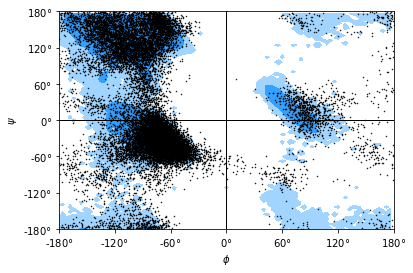

In [10]:
# Ramachandran angles for all the residues in val_protein. 
# To select a range of frames use .run(startframe,endframe+1)
val_rama = dihedrals.Ramachandran(val_protein).run()
val_rama.plot(color='black', marker='.', s=1, ref=True)
val_trj_phipsi = val_rama.results.angles
print(f'Ramachandran angles validation array shape: {val_trj_phipsi.shape}')

# Ramachandran angles for all the residues in test_protein.
test_rama = dihedrals.Ramachandran(test_protein).run()
test_trj_phipsi = test_rama.results.angles
print(f'Ramachandran angles test array shape: {test_trj_phipsi.shape}')

# Ramachandran angles for all the residues in all_protein.
all_rama = dihedrals.Ramachandran(all_protein).run()
all_trj_phipsi = all_rama.results.angles
print(f'Ramachandran angles all array shape: {all_trj_phipsi.shape}')

### Conversion of the trajectory into a lists of 4 symbols/frame.

Using simple selection of 4 attraction basins may ignore the actual distributions of angles during the dynamic. The function phipsi_to_basin offers the option to cluster the angles by k-means. We can shift the phi angles in order to obtain a better selection of basins.

In [11]:
def phipsi_to_basin(angles,phi_shift=-120.,cluster=False,n_clusters=4,plot=True):
    
    # Here, we reshape the sequence of frames so that the entire trajectory fits into 
    # a single 2D array for clustering
    shapes = angles.shape
    angles = np.reshape(angles,(shapes[0]*shapes[1],shapes[2]),order='C')

    # Shift in phi angles to obtain clean basins
    for value in angles:
        if value[1]<phi_shift:
            value[1] += 360.    

    init_centroids = np.array([[-100.,150],[-100.,-50.],[100.,-50.],[100.,150.]])
    kmeans = KMeans(n_clusters, 
                    init=init_centroids,
                    random_state=123,
                    algorithm='full').fit(angles)
    centroids = kmeans.cluster_centers_
    # score = kmeans.score(angles)
    
    if cluster:
        preds = kmeans.labels_
    else:
        preds = []
        for phipsi in angles:
            if phipsi[0]<=25. and phipsi[1]>70.:
                preds.append(0)
            elif phipsi[0]<=25. and phipsi[1]<=70.:
                preds.append(1)
            elif phipsi[0]>25. and phipsi[1]<=70.:
                preds.append(2)
            elif phipsi[0]>25. and phipsi[1]>70:
                preds.append(3)
        preds = np.array(preds) 
        
    if plot:
        x = [phipsi[0] for phipsi in angles]
        y = [phipsi[1] for phipsi in angles]

        # The scatter plot has markers colored by the basin cluster
        fig, (ax1) = plt.subplots(1,1)
        fig.set_figheight(5)
        fig.set_figwidth(7)
        fig.suptitle('Ramachandran plot with Basins predictions')
        scatterplot = ax1.scatter(x,y,s=1,c=preds)
        ax1.set_ylabel("psi angles")
        ax1.set_xlabel("phi angles")
        ax1.grid()

        # produce a legend with the unique colors from the scatter
        legend = ax1.legend(*scatterplot.legend_elements(),
                            loc="best", title="Classes")
        ax1.add_artist(legend)
        ax1.legend()
                
    basins = np.reshape(preds,(shapes[0],shapes[1]))
    angles = np.reshape(angles,(shapes[0],shapes[1],shapes[2]))            
        
    return angles,basins,centroids

### Basins 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


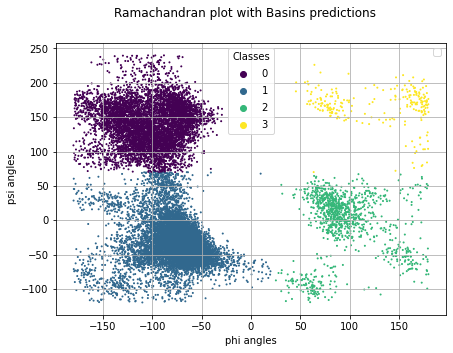

In [12]:
val_angles,val_basins,val_centroids = phipsi_to_basin(val_trj_phipsi,
                                                      phi_shift=-120.,
                                                      cluster=False,
                                                      n_clusters=4,
                                                      plot=True)


test_angles,test_basins,test_centroids = phipsi_to_basin(test_trj_phipsi,
                                                         phi_shift=-120.,
                                                         cluster=False,
                                                         n_clusters=4,
                                                         plot=False)


all_angles,all_basins,all_centroids = phipsi_to_basin(all_trj_phipsi,
                                                      phi_shift=-120.,
                                                      cluster=False,
                                                      n_clusters=4,
                                                      plot=False)

In [13]:
print(f'Validation centroids\n {val_centroids}')
print(f'Validation basin trj dimensions: {val_basins.shape}')
print(f'Validation basin trj: {val_basins}')

Validation centroids
 [[-102.97911129  137.48311941]
 [ -73.80445381  -35.30650969]
 [  94.83474066   -3.92823148]
 [ 127.8071452   166.7574127 ]]
Validation basin trj dimensions: (97, 212)
Validation basin trj: [[0 0 0 ... 1 1 1]
 [0 0 0 ... 1 1 1]
 [0 0 0 ... 1 1 1]
 ...
 [0 0 0 ... 1 1 1]
 [0 0 0 ... 1 1 1]
 [0 0 0 ... 1 1 1]]


Looks good: we can now use the predictions to convert the trj into an array of frames 
with each frame being an array of 4 symbols, one for each basin of attraction. First and last residues do not have phi-psi angles, so we only have 212 basins for the 214 residues of Adk.

### Datasets serving batches of inputs 

In [14]:
# Function to eliminate consecutive identical frames or 
# to skip frames in the basin trajectory
def reduce_basins(basins,ncycles,nskip):

    if ncycles == 0 and nskip > 1:
        trj = np.copy(basins)
        reduced_basins = np.array(trj[0::nskip,:])
    elif ncycles > 0 and nskip == 0:
        red_cycles = ncycles
        trj = np.copy(basins)

        for red_cycle in range(red_cycles):

            first_frame = np.array([trj[0]])
            # print(first_frame.shape,type(first_frame))

            count = 0
            reduced_trj = np.copy(first_frame)
            for i,frame in enumerate(trj):
                frame = np.array([frame])

                if i == 0:
                    previous_frame = first_frame

                if np.array_equal(previous_frame,frame):
                    previous_frame = frame
                    continue
                else:
                    count += 1
                    reduced_trj = np.append(reduced_trj,frame,axis=0)
                    previous_frame = frame

            # print(trj.shape)
            # print(count,reduced_trj.shape)
            trj = reduced_trj

        reduced_basins = trj
    
    return reduced_basins


# Function to pre-process basin trajectories
def preprocess_basins(basins,reduce = True,padding=2,reduce_cycles=2,skip_frames=0):
    if reduce:
        basins = reduce_basins(basins,reduce_cycles,skip_frames)
        
    n_frames = len(basins)   
    pad = np.zeros((padding,)) 
    basin_length = basins.shape[1] + 2*padding
    inputs = np.zeros((n_frames,basin_length))
    for i,basin_vec in enumerate(basins):
        basin_vec = (basin_vec + 1)/4
        basin_vec = np.concatenate((pad,basin_vec,pad),axis=0) 
        inputs[i] = basin_vec
        
    return inputs


# Function to extend dimensions
def preprocessing_fn(x):
    x = tf.expand_dims(x,axis=-1)
    return x


# Function to make a data.Dataset pipeline to serve batches of basin frames. 
# The number of parallel calls sets the number of cpu cores 
# used for serving data
def dataset_from_basin_trj(basins,reduce=True,padding=2,reduce_cycles=2,skip_frames=0,
                           batch_size='All',n_cpu=2,shuffle=True,
                           reshuffle=True,n_fetch=1,cache=False):
    
    inputs = preprocess_basins(basins,
                                reduce=reduce,
                                padding=padding,
                                reduce_cycles=reduce_cycles,
                                skip_frames=skip_frames)
    
    dataset = tf.data.Dataset.from_tensor_slices(inputs)
    dataset = dataset.map(preprocessing_fn,num_parallel_calls=n_cpu)

    # Here we shuffle from a number of elements at least as large as 
    # the number of frames in the dataset and prefetch in memory n_fetch batches 
    # to speed up processing
        
    n_frames = len(inputs)    

    if shuffle:
        dataset = dataset.shuffle(n_frames+1,reshuffle_each_iteration=reshuffle)

    if batch_size == 'All':
        batch_size = len(inputs)        

    dataset = dataset.batch(batch_size,
                            drop_remainder=True,
                            num_parallel_calls=n_cpu)
    
    dataset = dataset.prefetch(n_fetch).cache()
        
    return inputs,dataset

### Validation dataset

In [15]:
val_inputs,val_dataset = dataset_from_basin_trj(val_basins,
                                                reduce=True,
                                                reduce_cycles=2,
                                                skip_frames=0,
                                                padding=2,
                                                shuffle=True,
                                                batch_size=12,
                                                reshuffle=True,
                                                n_cpu=1,
                                                n_fetch=12)

print(f'Number of batches served: {len(val_dataset)}')

for inputs in val_dataset.take(1):
    print(f"Batch shape: {inputs.shape}")

# for i,element in enumerate(val_dataset.as_numpy_iterator()):
#     if i >= 7:
#         break
#     print(f'Element {i}:\n{element.shape}')

Number of batches served: 7
Batch shape: (12, 216, 1)


2022-06-03 09:30:58.442467: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-03 09:30:58.530321: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


### Test dataset

In [16]:
test_inputs,test_dataset = dataset_from_basin_trj(test_basins,
                                                  reduce=True,
                                                  reduce_cycles=2,
                                                  skip_frames=0,
                                                  padding=2,
                                                  shuffle=True,
                                                  batch_size=12,
                                                  reshuffle=True,
                                                  n_cpu=1,
                                                  n_fetch=12)

print(f'Number of batches served: {len(test_dataset)}')

for inputs in test_dataset.take(1):
    print(f"Batch shape: {inputs.shape}")

Number of batches served: 7
Batch shape: (12, 216, 1)


2022-06-03 09:30:58.722977: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


### All dataset

In [17]:
all_inputs,all_dataset = dataset_from_basin_trj(all_basins,
                                                reduce=True,
                                                reduce_cycles=2,
                                                skip_frames=0,
                                                padding=2,
                                                shuffle=True,
                                                batch_size=12,
                                                reshuffle=True,
                                                n_cpu=1,
                                                n_fetch=12)

print(f'Number of batches served: {len(all_dataset)}')

for inputs in all_dataset.take(1):
    print(f"Batch shape: {inputs.shape}")

Number of batches served: 1503
Batch shape: (12, 216, 1)


2022-06-03 09:38:01.742191: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


#### DEVICES

In [18]:
physical_devices_GPU = tf.config.list_physical_devices('GPU') 
print("Num GPUs:", len(physical_devices_GPU))

physical_devices_CPU = tf.config.list_physical_devices('CPU') 
print("Num CPUs:", len(physical_devices_CPU)) 

local_device_protos = device_lib.list_local_devices()
print(local_device_protos)


Num GPUs: 0
Num CPUs: 1
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8786396360261185518
xla_global_id: -1
]


### VAE

A variational autoencoder (VAE) turns an input into the parameters of a statistical distribution: a mean and a variance. The VAE then uses the mean and variance parameters to randomly sample one element of the distribution, and decodes that element back to the original input.

This is how our VAE works:

1. An `encoder` module turns the input basins vector into two parameters in a latent space of representations, `z_mean` and `z_log_variance`.

2. We randomly sample a point `z` from the latent distribution, *via* $z = z_{mean} + exp(z_{logvariance}) * \varepsilon$, where $\varepsilon$ is a random tensor of small values.

3. A `decoder` module maps this point in the latent space back to the original input basins vector.

Because $\varepsilon$ is random, the process ensures that every point that is close to a latent location where an input vector was encoded can be decoded to something similar to the input vector. Any two close points in the latent space will decode to highly similar vectors.

The parameters of a VAE are trained *via* two loss functions:

1. a `reconstruction loss` that forces the decoded samples to match the initial inputs, 
2. a `regularization loss` that helps learn a symmetric latent distributions centered at 0.

We train the model using the `reconstruction loss` and the `regularization loss`. For the regularization loss, we use the `Kullback–Leibler divergence`. 

**VAE model with custom `train_step()`**

Samples and targets are the same vectors of basins. So we cannot use any of the standard losses in Keras, and we have to run Tensorflow 'eagerly' with a defined loss (see '@property', below) and a new 'train_step',rather than from 'graph'.

In [19]:
class Sampler(layers.Layer):
    def call(self, z_mean, z_log_var):
        batch_size = tf.shape(z_mean)[0]
        z_size = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch_size, z_size))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

    
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.sampler = Sampler()
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [self.total_loss_tracker,
                self.reconstruction_loss_tracker,
                self.kl_loss_tracker]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var = self.encoder(data)
            z = self.sampler(z_mean, z_log_var)
            reconstruction = decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction),
                    axis=(1)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            total_loss = reconstruction_loss + tf.reduce_mean(kl_loss)
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "total_loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),           
        }

**VAE encoder network**

In [20]:
keras.backend.clear_session()
if 'encoder' in globals():
    del encoder
if 'decoder' in globals():
    del decoder
if 'vae' in globals():    
    del vae

In [21]:
keras.backend.clear_session()
latent_dim = 2
dataset_shapes = val_dataset.element_spec.shape.as_list()
print(dataset_shapes)

encoder_inputs = keras.Input(shape=(dataset_shapes[1:]))
x = layers.Conv1D(32, 4, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv1D(64, 4, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var], name="encoder")

encoder.summary()

[12, 216, 1]
Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 216, 1)]     0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 108, 32)      160         ['input_1[0][0]']                
                                                                                                  
 conv1d_1 (Conv1D)              (None, 54, 64)       8256        ['conv1d[0][0]']                 
                                                                                                  
 flatten (Flatten)              (None, 3456)         0           ['conv1d_1[0][0]']               
                                                                               

**VAE decoder network, mapping latent space points to images**

In [54]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(54 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((54, 64))(x)
x = layers.Conv1DTranspose(64, 4, activation="relu", strides=2, padding="same")(x)
x = layers.Conv1DTranspose(32, 4, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv1D(1, 4, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")

decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_1 (Dense)             (None, 3456)              10368     
                                                                 
 reshape_1 (Reshape)         (None, 54, 64)            0         
                                                                 
 conv1d_transpose_2 (Conv1DT  (None, 108, 64)          16448     
 ranspose)                                                       
                                                                 
 conv1d_transpose_3 (Conv1DT  (None, 216, 32)          8224      
 ranspose)                                                       
                                                                 
 conv1d_1 (Conv1D)           (None, 216, 1)            129 

**VAE compilation and saving**

In [23]:
# VAE compilation
vae = VAE(encoder,decoder)

# Saving of the untrained architecture
vae.encoder.save('encoder_model.tf',
        overwrite=True,include_optimizer=False,save_format='tf',
                 signatures=None,options=None)
vae.decoder.save('decoder_model.tf',
        overwrite=True,include_optimizer=False,save_format='tf',
                 signatures=None,options=None)

vae.encoder.save('encoder_model.h5',
        overwrite=True,include_optimizer=False,save_format='h5',
                 signatures=None,options=None)
vae.decoder.save('decoder_model.h5',
        overwrite=True,include_optimizer=False,save_format='h5',
                 signatures=None,options=None)

# Weight only saving
vae.encoder.save_weights('encoder_model_weights.h5', overwrite=True, 
                         save_format='h5', options=None)
vae.decoder.save_weights('decoder_model_weights.h5', overwrite=True, 
                         save_format='h5', options=None)

2022-06-03 09:38:03.590262: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: encoder_model.tf/assets
INFO:tensorflow:Assets written to: decoder_model.tf/assets


#### VAE training with only the validation data

In [24]:
n_epochs = 200

keras.backend.clear_session()
if 'encoder' in globals():
    del encoder
if 'decoder' in globals():
    del decoder
if 'val_vae' in globals():    
    del val_vae
       
# load encoder and decoder 
encoder = keras.models.load_model("encoder_model.tf")
decoder = keras.models.load_model("decoder_model.tf")

val_vae = VAE(encoder,decoder)
val_vae.compile(optimizer=keras.optimizers.Adam(), run_eagerly=True)

history_val_vae = val_vae.fit(val_dataset, epochs=n_epochs)

Epoch 1/200
7/7 [==============================] - 0s 46ms/step - total_loss: 149.1851 - reconstruction_loss: 149.1826 - kl_loss: 0.0024
Epoch 2/200
7/7 [==============================] - 0s 58ms/step - total_loss: 147.7520 - reconstruction_loss: 147.7077 - kl_loss: 0.0443
Epoch 3/200
7/7 [==============================] - 0s 57ms/step - total_loss: 146.6582 - reconstruction_loss: 146.6142 - kl_loss: 0.0441
Epoch 4/200
7/7 [==============================] - 0s 45ms/step - total_loss: 145.4577 - reconstruction_loss: 145.4268 - kl_loss: 0.0308
Epoch 5/200
7/7 [==============================] - 0s 43ms/step - total_loss: 143.7915 - reconstruction_loss: 143.5091 - kl_loss: 0.2824
Epoch 6/200
7/7 [==============================] - 0s 45ms/step - total_loss: 141.6918 - reconstruction_loss: 140.9141 - kl_loss: 0.7776
Epoch 7/200
7/7 [==============================] - 0s 41ms/step - total_loss: 139.9513 - reconstruction_loss: 139.2638 - kl_loss: 0.6875
Epoch 8/200
7/7 [========================

7/7 [==============================] - 0s 61ms/step - total_loss: 136.6753 - reconstruction_loss: 136.6750 - kl_loss: 2.5500e-04
Epoch 116/200
7/7 [==============================] - 0s 48ms/step - total_loss: 136.6819 - reconstruction_loss: 136.6817 - kl_loss: 2.2955e-04
Epoch 117/200
7/7 [==============================] - 0s 49ms/step - total_loss: 136.6831 - reconstruction_loss: 136.6829 - kl_loss: 1.6648e-04
Epoch 118/200
7/7 [==============================] - 0s 46ms/step - total_loss: 136.6738 - reconstruction_loss: 136.6737 - kl_loss: 1.4166e-04
Epoch 119/200
7/7 [==============================] - 0s 54ms/step - total_loss: 136.6777 - reconstruction_loss: 136.6776 - kl_loss: 1.5381e-04
Epoch 120/200
7/7 [==============================] - 0s 45ms/step - total_loss: 136.6739 - reconstruction_loss: 136.6737 - kl_loss: 1.7057e-04
Epoch 121/200
7/7 [==============================] - 0s 49ms/step - total_loss: 136.6803 - reconstruction_loss: 136.6802 - kl_loss: 1.3869e-04
Epoch 122/200

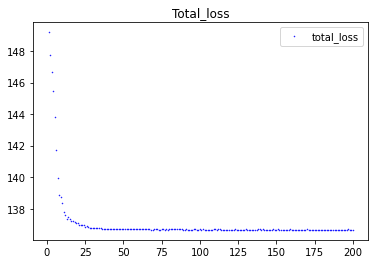

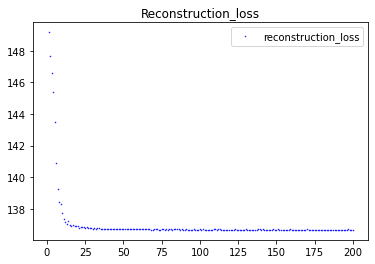

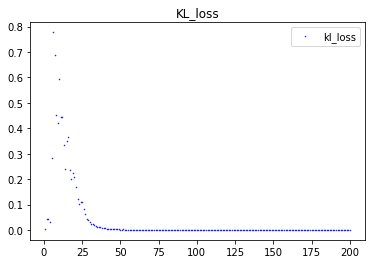

In [25]:
# Here we print the loss and accuracy
total_loss = history_val_vae.history["total_loss"]
reconstruction_loss = history_val_vae.history["reconstruction_loss"]
kl_loss = history_val_vae.history["kl_loss"]
 
epochs = range(1, len(total_loss)+1)

plt.figure()
plt.plot(epochs, total_loss, "b.", markersize=1, label="total_loss")
plt.title("Total_loss")
plt.legend()
plt.show()

plt.figure()
plt.plot(epochs, reconstruction_loss, "b.", markersize=1, label="reconstruction_loss")
plt.title("Reconstruction_loss")
plt.legend()
plt.show()

plt.figure()
plt.plot(epochs, kl_loss, "b.", markersize=1, label="kl_loss")
plt.title("KL_loss")
plt.legend()
plt.show()

In [26]:
# Saving of the trained vae
val_vae.encoder.save('val_encoder.tf',
        overwrite=True,include_optimizer=False,save_format='tf',
                 signatures=None,options=None)
val_vae.decoder.save('val_decoder.tf',
        overwrite=True,include_optimizer=False,save_format='tf',
                 signatures=None,options=None)

val_vae.encoder.save('val_encoder.h5',
        overwrite=True,include_optimizer=False,save_format='h5',
                 signatures=None,options=None)
val_vae.decoder.save('val_decoder.h5',
        overwrite=True,include_optimizer=False,save_format='h5',
                 signatures=None,options=None)

# Weight only saving
val_vae.encoder.save_weights('val_encoder_weights.h5', overwrite=True, 
                         save_format='h5', options=None)
val_vae.decoder.save_weights('val_decoder_weights.h5', overwrite=True, 
                         save_format='h5', options=None)

INFO:tensorflow:Assets written to: val_encoder.tf/assets
INFO:tensorflow:Assets written to: val_decoder.tf/assets


### Training with all the trajectories one at a time.

Here we iterate for 1 epochs trought all the trajectories in the ensemble starting from trajectory index=2, further refining the transformer model. This is what we consider a 'sub-epoch'. In each sub-epoch the training set is the current trajectory from the loop, while the validation set is always the trajectory with index=0. The number of batches served in each sub-epoch is determined by the number chosen for the execution of the dataset_from_basin_trj function. 

The number of true 'epochs' is the number of times we iterate over the entire ensemble. Currently, this loop saves memory, but unfortunately recalculates the rama angles in each epoch. It does not seem to slow down the fit, but in future we may put everything in memory from the start.

If the number of batches in 'dataset_from_basin_trj' is set to 'All', then the entire trajectory is served as a single batch, and the number of 'epochs' corresponds to the traditional definition of 'epoch' for the entire ensemble of trajectories.

### Training loop

In [27]:
total_loss_all = []
reconstruction_loss_all = []
kl_loss_all = []
history_vae_all = []

epochs = 10
sub_epochs = 1

keras.backend.clear_session()
if 'encoder' in globals():
    del encoder
if 'decoder' in globals():
    del decoder
if 'all_vae' in globals():    
    del all_vae
       
# load encoder and decoder 
encoder = keras.models.load_model("encoder_model.tf")
decoder = keras.models.load_model("decoder_model.tf")

all_vae = VAE(encoder, decoder)
all_vae.compile(optimizer=keras.optimizers.Adam(), run_eagerly=True)

for epoch in range(epochs):
    start_frame = 0
    end_frame = 0    
    for nframes in all_trj_nframes:
        start_frame = end_frame        
        print(nframes,'\n')
        end_frame = start_frame + nframes
        print(f'epoch: {epoch+1}, frames: {start_frame}:{end_frame}')
        
        
        _,basins,_ = phipsi_to_basin(all_trj_phipsi[start_frame:end_frame,:,:],
                                     phi_shift=-120.,
                                     cluster=False,
                                     n_clusters=4,
                                     plot=False)
        _,dataset = dataset_from_basin_trj(basins,
                                           reduce=True,
                                           reduce_cycles=2,
                                           skip_frames=0,
                                           padding=2,
                                           shuffle=True,
                                           batch_size=12,
                                           reshuffle=True,
                                           n_cpu=1,
                                           n_fetch=12)
        
            
        history_all_vae = all_vae.fit(dataset, epochs=sub_epochs)            
    
        total_loss = history_all_vae.history["total_loss"]
        reconstruction_loss = history_all_vae.history["reconstruction_loss"]
        kl_loss = history_all_vae.history["kl_loss"]

        history_vae_all.append(history_all_vae)
        total_loss_all.append(total_loss)
        reconstruction_loss_all.append(reconstruction_loss)
        kl_loss_all.append(kl_loss)
        

97 

epoch: 1, frames: 0:97
7/7 [==============================] - 1s 87ms/step - total_loss: 149.1993 - reconstruction_loss: 149.1962 - kl_loss: 0.0031
97 

epoch: 1, frames: 97:194
7/7 [==============================] - 0s 53ms/step - total_loss: 147.5443 - reconstruction_loss: 147.5143 - kl_loss: 0.0300
98 

epoch: 1, frames: 194:292
7/7 [==============================] - 0s 57ms/step - total_loss: 146.6077 - reconstruction_loss: 146.5870 - kl_loss: 0.0206
95 

epoch: 1, frames: 292:387
7/7 [==============================] - 0s 48ms/step - total_loss: 145.6273 - reconstruction_loss: 145.6234 - kl_loss: 0.0039
100 

epoch: 1, frames: 387:487
7/7 [==============================] - 0s 47ms/step - total_loss: 144.0186 - reconstruction_loss: 144.0063 - kl_loss: 0.0122
98 

epoch: 1, frames: 487:585
7/7 [==============================] - 0s 53ms/step - total_loss: 142.1340 - reconstruction_loss: 142.0862 - kl_loss: 0.0479
97 

epoch: 1, frames: 585:682
7/7 [==============================]

6/6 [==============================] - 0s 47ms/step - total_loss: 137.2850 - reconstruction_loss: 137.2845 - kl_loss: 5.2119e-04
100 

epoch: 1, frames: 5023:5123
7/7 [==============================] - 0s 54ms/step - total_loss: 136.4646 - reconstruction_loss: 136.4638 - kl_loss: 8.1404e-04
101 

epoch: 1, frames: 5123:5224
7/7 [==============================] - 0s 50ms/step - total_loss: 136.6102 - reconstruction_loss: 136.6091 - kl_loss: 0.0011
100 

epoch: 1, frames: 5224:5324
7/7 [==============================] - 0s 46ms/step - total_loss: 136.6646 - reconstruction_loss: 136.6637 - kl_loss: 9.5864e-04
99 

epoch: 1, frames: 5324:5423
7/7 [==============================] - 1s 81ms/step - total_loss: 137.1664 - reconstruction_loss: 137.1654 - kl_loss: 0.0010
103 

epoch: 1, frames: 5423:5526
8/8 [==============================] - 0s 50ms/step - total_loss: 136.7469 - reconstruction_loss: 136.7459 - kl_loss: 0.0011
103 

epoch: 1, frames: 5526:5629
8/8 [==============================

8/8 [==============================] - 0s 43ms/step - total_loss: 136.3176 - reconstruction_loss: 136.3174 - kl_loss: 1.5987e-04
99 

epoch: 1, frames: 14854:14953
7/7 [==============================] - 0s 46ms/step - total_loss: 136.1591 - reconstruction_loss: 136.1590 - kl_loss: 1.4770e-04
93 

epoch: 1, frames: 14953:15046
7/7 [==============================] - 0s 48ms/step - total_loss: 136.4604 - reconstruction_loss: 136.4603 - kl_loss: 1.3686e-04
98 

epoch: 1, frames: 15046:15144
7/7 [==============================] - 0s 46ms/step - total_loss: 136.6786 - reconstruction_loss: 136.6784 - kl_loss: 1.3222e-04
98 

epoch: 1, frames: 15144:15242
7/7 [==============================] - 0s 46ms/step - total_loss: 136.5935 - reconstruction_loss: 136.5933 - kl_loss: 1.2970e-04
97 

epoch: 1, frames: 15242:15339
7/7 [==============================] - 0s 42ms/step - total_loss: 136.5336 - reconstruction_loss: 136.5334 - kl_loss: 1.2991e-04
96 

epoch: 1, frames: 15339:15435
7/7 [===========

7/7 [==============================] - 0s 45ms/step - total_loss: 137.0092 - reconstruction_loss: 137.0091 - kl_loss: 1.1664e-04
97 

epoch: 2, frames: 97:194
7/7 [==============================] - 0s 59ms/step - total_loss: 136.8233 - reconstruction_loss: 136.8232 - kl_loss: 1.1267e-04
98 

epoch: 2, frames: 194:292
7/7 [==============================] - 0s 41ms/step - total_loss: 136.5799 - reconstruction_loss: 136.5798 - kl_loss: 1.0832e-04
95 

epoch: 2, frames: 292:387
7/7 [==============================] - 1s 90ms/step - total_loss: 136.2066 - reconstruction_loss: 136.2065 - kl_loss: 1.0174e-04
100 

epoch: 2, frames: 387:487
7/7 [==============================] - 0s 51ms/step - total_loss: 136.9297 - reconstruction_loss: 136.9296 - kl_loss: 9.4895e-05
98 

epoch: 2, frames: 487:585
7/7 [==============================] - 0s 51ms/step - total_loss: 136.2916 - reconstruction_loss: 136.2915 - kl_loss: 9.4475e-05
97 

epoch: 2, frames: 585:682
7/7 [==============================] - 0

7/7 [==============================] - 0s 48ms/step - total_loss: 137.0052 - reconstruction_loss: 137.0050 - kl_loss: 1.1705e-04
100 

epoch: 2, frames: 9947:10047
8/8 [==============================] - 0s 52ms/step - total_loss: 136.7056 - reconstruction_loss: 136.7054 - kl_loss: 1.2577e-04
91 

epoch: 2, frames: 10047:10138
7/7 [==============================] - 0s 51ms/step - total_loss: 136.5086 - reconstruction_loss: 136.5085 - kl_loss: 1.1750e-04
96 

epoch: 2, frames: 10138:10234
7/7 [==============================] - 0s 46ms/step - total_loss: 136.8197 - reconstruction_loss: 136.8196 - kl_loss: 1.0382e-04
98 

epoch: 2, frames: 10234:10332
7/7 [==============================] - 0s 46ms/step - total_loss: 136.6819 - reconstruction_loss: 136.6818 - kl_loss: 1.0188e-04
94 

epoch: 2, frames: 10332:10426
7/7 [==============================] - 0s 45ms/step - total_loss: 136.4770 - reconstruction_loss: 136.4769 - kl_loss: 8.4628e-05
97 

epoch: 2, frames: 10426:10523
7/7 [===========

8/8 [==============================] - 0s 50ms/step - total_loss: 136.3152 - reconstruction_loss: 136.3151 - kl_loss: 4.9429e-05
99 

epoch: 2, frames: 14854:14953
7/7 [==============================] - 0s 45ms/step - total_loss: 136.1467 - reconstruction_loss: 136.1467 - kl_loss: 3.6917e-05
93 

epoch: 2, frames: 14953:15046
7/7 [==============================] - 0s 46ms/step - total_loss: 136.4392 - reconstruction_loss: 136.4392 - kl_loss: 2.8676e-05
98 

epoch: 2, frames: 15046:15144
7/7 [==============================] - 0s 50ms/step - total_loss: 136.6499 - reconstruction_loss: 136.6498 - kl_loss: 2.7955e-05
98 

epoch: 2, frames: 15144:15242
7/7 [==============================] - 0s 48ms/step - total_loss: 136.6007 - reconstruction_loss: 136.6007 - kl_loss: 3.1022e-05
97 

epoch: 2, frames: 15242:15339
7/7 [==============================] - 0s 46ms/step - total_loss: 136.5079 - reconstruction_loss: 136.5079 - kl_loss: 4.0325e-05
96 

epoch: 2, frames: 15339:15435
7/7 [===========

7/7 [==============================] - 0s 47ms/step - total_loss: 137.0228 - reconstruction_loss: 137.0228 - kl_loss: 5.1515e-05
97 

epoch: 3, frames: 97:194
7/7 [==============================] - 0s 49ms/step - total_loss: 136.8013 - reconstruction_loss: 136.8013 - kl_loss: 4.2794e-05
98 

epoch: 3, frames: 194:292
7/7 [==============================] - 0s 53ms/step - total_loss: 136.5747 - reconstruction_loss: 136.5747 - kl_loss: 3.9895e-05
95 

epoch: 3, frames: 292:387
7/7 [==============================] - 0s 46ms/step - total_loss: 136.1950 - reconstruction_loss: 136.1950 - kl_loss: 3.6116e-05
100 

epoch: 3, frames: 387:487
7/7 [==============================] - 0s 45ms/step - total_loss: 136.9224 - reconstruction_loss: 136.9224 - kl_loss: 3.1356e-05
98 

epoch: 3, frames: 487:585
7/7 [==============================] - 0s 47ms/step - total_loss: 136.3026 - reconstruction_loss: 136.3025 - kl_loss: 3.2504e-05
97 

epoch: 3, frames: 585:682
7/7 [==============================] - 0

7/7 [==============================] - 0s 46ms/step - total_loss: 137.0104 - reconstruction_loss: 137.0103 - kl_loss: 5.2822e-05
100 

epoch: 3, frames: 9947:10047
8/8 [==============================] - 0s 47ms/step - total_loss: 136.7046 - reconstruction_loss: 136.7046 - kl_loss: 5.4888e-05
91 

epoch: 3, frames: 10047:10138
7/7 [==============================] - 0s 45ms/step - total_loss: 136.4743 - reconstruction_loss: 136.4743 - kl_loss: 5.4227e-05
96 

epoch: 3, frames: 10138:10234
7/7 [==============================] - 0s 47ms/step - total_loss: 136.8507 - reconstruction_loss: 136.8507 - kl_loss: 5.1320e-05
98 

epoch: 3, frames: 10234:10332
7/7 [==============================] - 0s 43ms/step - total_loss: 136.6369 - reconstruction_loss: 136.6369 - kl_loss: 3.9320e-05
94 

epoch: 3, frames: 10332:10426
7/7 [==============================] - 0s 50ms/step - total_loss: 136.4392 - reconstruction_loss: 136.4391 - kl_loss: 7.3997e-05
97 

epoch: 3, frames: 10426:10523
7/7 [===========

8/8 [==============================] - 0s 48ms/step - total_loss: 136.3039 - reconstruction_loss: 136.3039 - kl_loss: 1.2688e-05
99 

epoch: 3, frames: 14854:14953
7/7 [==============================] - 0s 45ms/step - total_loss: 136.1375 - reconstruction_loss: 136.1375 - kl_loss: 1.6021e-05
93 

epoch: 3, frames: 14953:15046
7/7 [==============================] - 0s 45ms/step - total_loss: 136.4352 - reconstruction_loss: 136.4352 - kl_loss: 2.6103e-05
98 

epoch: 3, frames: 15046:15144
7/7 [==============================] - 0s 46ms/step - total_loss: 136.6457 - reconstruction_loss: 136.6457 - kl_loss: 2.7791e-05
98 

epoch: 3, frames: 15144:15242
7/7 [==============================] - 0s 44ms/step - total_loss: 136.5850 - reconstruction_loss: 136.5849 - kl_loss: 2.3233e-05
97 

epoch: 3, frames: 15242:15339
7/7 [==============================] - 0s 47ms/step - total_loss: 136.5097 - reconstruction_loss: 136.5096 - kl_loss: 3.1418e-05
96 

epoch: 3, frames: 15339:15435
7/7 [===========

7/7 [==============================] - 0s 47ms/step - total_loss: 137.0393 - reconstruction_loss: 137.0392 - kl_loss: 1.2268e-05
97 

epoch: 4, frames: 97:194
7/7 [==============================] - 0s 46ms/step - total_loss: 136.7898 - reconstruction_loss: 136.7897 - kl_loss: 1.4156e-05
98 

epoch: 4, frames: 194:292
7/7 [==============================] - 0s 46ms/step - total_loss: 136.5705 - reconstruction_loss: 136.5705 - kl_loss: 1.6204e-05
95 

epoch: 4, frames: 292:387
7/7 [==============================] - 0s 43ms/step - total_loss: 136.1918 - reconstruction_loss: 136.1918 - kl_loss: 1.4109e-05
100 

epoch: 4, frames: 387:487
7/7 [==============================] - 0s 45ms/step - total_loss: 136.9262 - reconstruction_loss: 136.9262 - kl_loss: 1.0759e-05
98 

epoch: 4, frames: 487:585
7/7 [==============================] - 0s 46ms/step - total_loss: 136.3186 - reconstruction_loss: 136.3185 - kl_loss: 1.4079e-05
97 

epoch: 4, frames: 585:682
7/7 [==============================] - 0

7/7 [==============================] - 0s 48ms/step - total_loss: 137.0127 - reconstruction_loss: 137.0127 - kl_loss: 2.8925e-05
100 

epoch: 4, frames: 9947:10047
8/8 [==============================] - 0s 49ms/step - total_loss: 136.6985 - reconstruction_loss: 136.6984 - kl_loss: 3.0683e-05
91 

epoch: 4, frames: 10047:10138
7/7 [==============================] - 0s 47ms/step - total_loss: 136.4914 - reconstruction_loss: 136.4913 - kl_loss: 2.4617e-05
96 

epoch: 4, frames: 10138:10234
7/7 [==============================] - 0s 46ms/step - total_loss: 136.8683 - reconstruction_loss: 136.8683 - kl_loss: 3.2133e-05
98 

epoch: 4, frames: 10234:10332
7/7 [==============================] - 0s 45ms/step - total_loss: 136.6119 - reconstruction_loss: 136.6119 - kl_loss: 5.5692e-05
94 

epoch: 4, frames: 10332:10426
7/7 [==============================] - 0s 47ms/step - total_loss: 136.4424 - reconstruction_loss: 136.4423 - kl_loss: 3.8615e-05
97 

epoch: 4, frames: 10426:10523
7/7 [===========

8/8 [==============================] - 0s 48ms/step - total_loss: 136.3063 - reconstruction_loss: 136.3062 - kl_loss: 2.3179e-05
99 

epoch: 4, frames: 14854:14953
7/7 [==============================] - 0s 45ms/step - total_loss: 136.1570 - reconstruction_loss: 136.1570 - kl_loss: 3.9107e-05
93 

epoch: 4, frames: 14953:15046
7/7 [==============================] - 0s 43ms/step - total_loss: 136.4262 - reconstruction_loss: 136.4261 - kl_loss: 4.1504e-05
98 

epoch: 4, frames: 15046:15144
7/7 [==============================] - 0s 49ms/step - total_loss: 136.6372 - reconstruction_loss: 136.6372 - kl_loss: 3.1071e-05
98 

epoch: 4, frames: 15144:15242
7/7 [==============================] - 0s 45ms/step - total_loss: 136.6293 - reconstruction_loss: 136.6293 - kl_loss: 2.5132e-05
97 

epoch: 4, frames: 15242:15339
7/7 [==============================] - 0s 44ms/step - total_loss: 136.5216 - reconstruction_loss: 136.5215 - kl_loss: 2.7165e-05
96 

epoch: 4, frames: 15339:15435
7/7 [===========

7/7 [==============================] - 0s 49ms/step - total_loss: 137.0342 - reconstruction_loss: 137.0342 - kl_loss: 1.7901e-05
97 

epoch: 5, frames: 97:194
7/7 [==============================] - 0s 43ms/step - total_loss: 136.7883 - reconstruction_loss: 136.7883 - kl_loss: 1.2781e-05
98 

epoch: 5, frames: 194:292
7/7 [==============================] - 0s 46ms/step - total_loss: 136.5602 - reconstruction_loss: 136.5602 - kl_loss: 9.8582e-06
95 

epoch: 5, frames: 292:387
7/7 [==============================] - 0s 43ms/step - total_loss: 136.1864 - reconstruction_loss: 136.1864 - kl_loss: 8.9620e-06
100 

epoch: 5, frames: 387:487
7/7 [==============================] - 0s 44ms/step - total_loss: 136.9266 - reconstruction_loss: 136.9266 - kl_loss: 5.9072e-06
98 

epoch: 5, frames: 487:585
7/7 [==============================] - 0s 44ms/step - total_loss: 136.3336 - reconstruction_loss: 136.3335 - kl_loss: 8.4255e-06
97 

epoch: 5, frames: 585:682
7/7 [==============================] - 0

7/7 [==============================] - 0s 46ms/step - total_loss: 136.9853 - reconstruction_loss: 136.9852 - kl_loss: 9.4857e-05
100 

epoch: 5, frames: 9947:10047
8/8 [==============================] - 0s 43ms/step - total_loss: 136.6692 - reconstruction_loss: 136.6691 - kl_loss: 7.2211e-05
91 

epoch: 5, frames: 10047:10138
7/7 [==============================] - 0s 49ms/step - total_loss: 136.4598 - reconstruction_loss: 136.4598 - kl_loss: 4.6168e-05
96 

epoch: 5, frames: 10138:10234
7/7 [==============================] - 0s 45ms/step - total_loss: 136.8622 - reconstruction_loss: 136.8622 - kl_loss: 4.0240e-05
98 

epoch: 5, frames: 10234:10332
7/7 [==============================] - 0s 46ms/step - total_loss: 136.5914 - reconstruction_loss: 136.5913 - kl_loss: 4.5772e-05
94 

epoch: 5, frames: 10332:10426
7/7 [==============================] - 0s 44ms/step - total_loss: 136.4359 - reconstruction_loss: 136.4358 - kl_loss: 4.1864e-05
97 

epoch: 5, frames: 10426:10523
7/7 [===========

8/8 [==============================] - 0s 53ms/step - total_loss: 136.3102 - reconstruction_loss: 136.3102 - kl_loss: 1.4154e-05
99 

epoch: 5, frames: 14854:14953
7/7 [==============================] - 0s 46ms/step - total_loss: 136.1341 - reconstruction_loss: 136.1341 - kl_loss: 3.6976e-06
93 

epoch: 5, frames: 14953:15046
7/7 [==============================] - 0s 46ms/step - total_loss: 136.4210 - reconstruction_loss: 136.4210 - kl_loss: 2.9185e-06
98 

epoch: 5, frames: 15046:15144
7/7 [==============================] - 0s 47ms/step - total_loss: 136.6317 - reconstruction_loss: 136.6317 - kl_loss: 6.9972e-06
98 

epoch: 5, frames: 15144:15242
7/7 [==============================] - 0s 46ms/step - total_loss: 136.6005 - reconstruction_loss: 136.6005 - kl_loss: 1.1225e-05
97 

epoch: 5, frames: 15242:15339
7/7 [==============================] - 0s 47ms/step - total_loss: 136.5022 - reconstruction_loss: 136.5022 - kl_loss: 2.1473e-05
96 

epoch: 5, frames: 15339:15435
7/7 [===========

7/7 [==============================] - 0s 45ms/step - total_loss: 137.0082 - reconstruction_loss: 137.0082 - kl_loss: 1.5993e-05
97 

epoch: 6, frames: 97:194
7/7 [==============================] - 0s 46ms/step - total_loss: 136.7893 - reconstruction_loss: 136.7893 - kl_loss: 2.4131e-05
98 

epoch: 6, frames: 194:292
7/7 [==============================] - 0s 45ms/step - total_loss: 136.5726 - reconstruction_loss: 136.5726 - kl_loss: 3.4852e-05
95 

epoch: 6, frames: 292:387
7/7 [==============================] - 0s 46ms/step - total_loss: 136.1721 - reconstruction_loss: 136.1721 - kl_loss: 3.5011e-05
100 

epoch: 6, frames: 387:487
7/7 [==============================] - 0s 45ms/step - total_loss: 136.9373 - reconstruction_loss: 136.9373 - kl_loss: 2.0332e-05
98 

epoch: 6, frames: 487:585
7/7 [==============================] - 0s 45ms/step - total_loss: 136.3366 - reconstruction_loss: 136.3366 - kl_loss: 1.1734e-05
97 

epoch: 6, frames: 585:682
7/7 [==============================] - 0

7/7 [==============================] - 0s 47ms/step - total_loss: 136.9365 - reconstruction_loss: 136.9365 - kl_loss: 5.4511e-05
100 

epoch: 6, frames: 9947:10047
8/8 [==============================] - 0s 48ms/step - total_loss: 136.6745 - reconstruction_loss: 136.6745 - kl_loss: 5.1321e-05
91 

epoch: 6, frames: 10047:10138
7/7 [==============================] - 0s 48ms/step - total_loss: 136.4747 - reconstruction_loss: 136.4747 - kl_loss: 2.5575e-05
96 

epoch: 6, frames: 10138:10234
7/7 [==============================] - 0s 48ms/step - total_loss: 136.8936 - reconstruction_loss: 136.8936 - kl_loss: 1.0386e-05
98 

epoch: 6, frames: 10234:10332
7/7 [==============================] - 0s 47ms/step - total_loss: 136.5665 - reconstruction_loss: 136.5665 - kl_loss: 1.2008e-05
94 

epoch: 6, frames: 10332:10426
7/7 [==============================] - 0s 45ms/step - total_loss: 136.4349 - reconstruction_loss: 136.4349 - kl_loss: 3.1705e-05
97 

epoch: 6, frames: 10426:10523
7/7 [===========

8/8 [==============================] - 0s 45ms/step - total_loss: 136.3078 - reconstruction_loss: 136.3078 - kl_loss: 1.5758e-05
99 

epoch: 6, frames: 14854:14953
7/7 [==============================] - 0s 44ms/step - total_loss: 136.1490 - reconstruction_loss: 136.1490 - kl_loss: 3.9011e-05
93 

epoch: 6, frames: 14953:15046
7/7 [==============================] - 0s 45ms/step - total_loss: 136.4215 - reconstruction_loss: 136.4215 - kl_loss: 3.9467e-05
98 

epoch: 6, frames: 15046:15144
7/7 [==============================] - 0s 46ms/step - total_loss: 136.6303 - reconstruction_loss: 136.6303 - kl_loss: 2.1873e-05
98 

epoch: 6, frames: 15144:15242
7/7 [==============================] - 0s 43ms/step - total_loss: 136.5967 - reconstruction_loss: 136.5967 - kl_loss: 1.4797e-05
97 

epoch: 6, frames: 15242:15339
7/7 [==============================] - 0s 46ms/step - total_loss: 136.4951 - reconstruction_loss: 136.4951 - kl_loss: 2.3171e-05
96 

epoch: 6, frames: 15339:15435
7/7 [===========

7/7 [==============================] - 0s 44ms/step - total_loss: 136.9674 - reconstruction_loss: 136.9673 - kl_loss: 1.0446e-05
97 

epoch: 7, frames: 97:194
7/7 [==============================] - 0s 48ms/step - total_loss: 136.7928 - reconstruction_loss: 136.7927 - kl_loss: 1.9587e-05
98 

epoch: 7, frames: 194:292
7/7 [==============================] - 0s 44ms/step - total_loss: 136.5642 - reconstruction_loss: 136.5641 - kl_loss: 2.4112e-05
95 

epoch: 7, frames: 292:387
7/7 [==============================] - 0s 47ms/step - total_loss: 136.1751 - reconstruction_loss: 136.1750 - kl_loss: 1.4471e-05
100 

epoch: 7, frames: 387:487
7/7 [==============================] - 0s 49ms/step - total_loss: 136.9595 - reconstruction_loss: 136.9595 - kl_loss: 1.0963e-05
98 

epoch: 7, frames: 487:585
7/7 [==============================] - 0s 53ms/step - total_loss: 136.3439 - reconstruction_loss: 136.3439 - kl_loss: 1.8556e-05
97 

epoch: 7, frames: 585:682
7/7 [==============================] - 0

7/7 [==============================] - 0s 46ms/step - total_loss: 136.9688 - reconstruction_loss: 136.9687 - kl_loss: 7.7028e-05
100 

epoch: 7, frames: 9947:10047
8/8 [==============================] - 0s 47ms/step - total_loss: 136.6775 - reconstruction_loss: 136.6774 - kl_loss: 7.5934e-05
91 

epoch: 7, frames: 10047:10138
7/7 [==============================] - 0s 46ms/step - total_loss: 136.4615 - reconstruction_loss: 136.4615 - kl_loss: 6.2193e-05
96 

epoch: 7, frames: 10138:10234
7/7 [==============================] - 0s 48ms/step - total_loss: 136.8930 - reconstruction_loss: 136.8930 - kl_loss: 4.8112e-05
98 

epoch: 7, frames: 10234:10332
7/7 [==============================] - 0s 51ms/step - total_loss: 136.5594 - reconstruction_loss: 136.5593 - kl_loss: 2.7806e-05
94 

epoch: 7, frames: 10332:10426
7/7 [==============================] - 0s 49ms/step - total_loss: 136.4251 - reconstruction_loss: 136.4251 - kl_loss: 6.1240e-05
97 

epoch: 7, frames: 10426:10523
7/7 [===========

8/8 [==============================] - 0s 44ms/step - total_loss: 136.3017 - reconstruction_loss: 136.3017 - kl_loss: 1.5093e-05
99 

epoch: 7, frames: 14854:14953
7/7 [==============================] - 0s 47ms/step - total_loss: 136.1496 - reconstruction_loss: 136.1495 - kl_loss: 2.4046e-05
93 

epoch: 7, frames: 14953:15046
7/7 [==============================] - 0s 47ms/step - total_loss: 136.4179 - reconstruction_loss: 136.4179 - kl_loss: 1.5989e-05
98 

epoch: 7, frames: 15046:15144
7/7 [==============================] - 0s 46ms/step - total_loss: 136.6299 - reconstruction_loss: 136.6299 - kl_loss: 6.8503e-06
98 

epoch: 7, frames: 15144:15242
7/7 [==============================] - 0s 46ms/step - total_loss: 136.6009 - reconstruction_loss: 136.6008 - kl_loss: 7.4995e-06
97 

epoch: 7, frames: 15242:15339
7/7 [==============================] - 0s 46ms/step - total_loss: 136.5044 - reconstruction_loss: 136.5044 - kl_loss: 1.6042e-05
96 

epoch: 7, frames: 15339:15435
7/7 [===========

7/7 [==============================] - 0s 58ms/step - total_loss: 137.0050 - reconstruction_loss: 137.0050 - kl_loss: 8.9918e-06
97 

epoch: 8, frames: 97:194
7/7 [==============================] - 0s 50ms/step - total_loss: 136.7967 - reconstruction_loss: 136.7967 - kl_loss: 1.6470e-05
98 

epoch: 8, frames: 194:292
7/7 [==============================] - 0s 62ms/step - total_loss: 136.5849 - reconstruction_loss: 136.5849 - kl_loss: 2.4095e-05
95 

epoch: 8, frames: 292:387
7/7 [==============================] - 0s 51ms/step - total_loss: 136.1615 - reconstruction_loss: 136.1614 - kl_loss: 2.0664e-05
100 

epoch: 8, frames: 387:487
7/7 [==============================] - 0s 59ms/step - total_loss: 136.9170 - reconstruction_loss: 136.9170 - kl_loss: 9.5495e-06
98 

epoch: 8, frames: 487:585
7/7 [==============================] - 1s 74ms/step - total_loss: 136.3363 - reconstruction_loss: 136.3363 - kl_loss: 3.9254e-06
97 

epoch: 8, frames: 585:682
7/7 [==============================] - 0

7/7 [==============================] - 0s 46ms/step - total_loss: 136.9633 - reconstruction_loss: 136.9633 - kl_loss: 1.7422e-05
100 

epoch: 8, frames: 9947:10047
8/8 [==============================] - 0s 44ms/step - total_loss: 136.6886 - reconstruction_loss: 136.6885 - kl_loss: 1.4385e-05
91 

epoch: 8, frames: 10047:10138
7/7 [==============================] - 0s 44ms/step - total_loss: 136.4676 - reconstruction_loss: 136.4676 - kl_loss: 1.0616e-05
96 

epoch: 8, frames: 10138:10234
7/7 [==============================] - 0s 50ms/step - total_loss: 136.8948 - reconstruction_loss: 136.8948 - kl_loss: 1.1814e-05
98 

epoch: 8, frames: 10234:10332
7/7 [==============================] - 0s 46ms/step - total_loss: 136.5458 - reconstruction_loss: 136.5458 - kl_loss: 1.1074e-05
94 

epoch: 8, frames: 10332:10426
7/7 [==============================] - 0s 46ms/step - total_loss: 136.4129 - reconstruction_loss: 136.4129 - kl_loss: 1.8682e-05
97 

epoch: 8, frames: 10426:10523
7/7 [===========

8/8 [==============================] - 0s 43ms/step - total_loss: 136.2976 - reconstruction_loss: 136.2976 - kl_loss: 9.9353e-06
99 

epoch: 8, frames: 14854:14953
7/7 [==============================] - 0s 43ms/step - total_loss: 136.1508 - reconstruction_loss: 136.1508 - kl_loss: 1.2289e-05
93 

epoch: 8, frames: 14953:15046
7/7 [==============================] - 0s 48ms/step - total_loss: 136.4146 - reconstruction_loss: 136.4146 - kl_loss: 1.6804e-05
98 

epoch: 8, frames: 15046:15144
7/7 [==============================] - 0s 46ms/step - total_loss: 136.6317 - reconstruction_loss: 136.6317 - kl_loss: 7.6209e-06
98 

epoch: 8, frames: 15144:15242
7/7 [==============================] - 0s 45ms/step - total_loss: 136.5883 - reconstruction_loss: 136.5883 - kl_loss: 4.7343e-06
97 

epoch: 8, frames: 15242:15339
7/7 [==============================] - 0s 46ms/step - total_loss: 136.4979 - reconstruction_loss: 136.4978 - kl_loss: 3.2638e-05
96 

epoch: 8, frames: 15339:15435
7/7 [===========

7/7 [==============================] - 0s 47ms/step - total_loss: 136.9859 - reconstruction_loss: 136.9859 - kl_loss: 1.2304e-05
97 

epoch: 9, frames: 97:194
7/7 [==============================] - 0s 49ms/step - total_loss: 136.8013 - reconstruction_loss: 136.8013 - kl_loss: 1.2896e-05
98 

epoch: 9, frames: 194:292
7/7 [==============================] - 0s 46ms/step - total_loss: 136.5811 - reconstruction_loss: 136.5811 - kl_loss: 1.3130e-05
95 

epoch: 9, frames: 292:387
7/7 [==============================] - 0s 47ms/step - total_loss: 136.1752 - reconstruction_loss: 136.1752 - kl_loss: 1.5350e-05
100 

epoch: 9, frames: 387:487
7/7 [==============================] - 0s 50ms/step - total_loss: 136.9085 - reconstruction_loss: 136.9085 - kl_loss: 2.0070e-05
98 

epoch: 9, frames: 487:585
7/7 [==============================] - 0s 47ms/step - total_loss: 136.3421 - reconstruction_loss: 136.3420 - kl_loss: 2.8566e-05
97 

epoch: 9, frames: 585:682
7/7 [==============================] - 0

7/7 [==============================] - 0s 48ms/step - total_loss: 136.9753 - reconstruction_loss: 136.9752 - kl_loss: 3.5771e-05
100 

epoch: 9, frames: 9947:10047
8/8 [==============================] - 0s 47ms/step - total_loss: 136.6645 - reconstruction_loss: 136.6645 - kl_loss: 3.8447e-05
91 

epoch: 9, frames: 10047:10138
7/7 [==============================] - 0s 50ms/step - total_loss: 136.4641 - reconstruction_loss: 136.4640 - kl_loss: 1.8827e-05
96 

epoch: 9, frames: 10138:10234
7/7 [==============================] - 0s 48ms/step - total_loss: 136.8667 - reconstruction_loss: 136.8667 - kl_loss: 2.8738e-06
98 

epoch: 9, frames: 10234:10332
7/7 [==============================] - 0s 46ms/step - total_loss: 136.5365 - reconstruction_loss: 136.5365 - kl_loss: 7.0440e-06
94 

epoch: 9, frames: 10332:10426
7/7 [==============================] - 0s 46ms/step - total_loss: 136.4197 - reconstruction_loss: 136.4197 - kl_loss: 7.3825e-06
97 

epoch: 9, frames: 10426:10523
7/7 [===========

8/8 [==============================] - 0s 59ms/step - total_loss: 136.2998 - reconstruction_loss: 136.2998 - kl_loss: 5.0962e-06
99 

epoch: 9, frames: 14854:14953
7/7 [==============================] - 0s 50ms/step - total_loss: 136.1280 - reconstruction_loss: 136.1280 - kl_loss: 3.2761e-06
93 

epoch: 9, frames: 14953:15046
7/7 [==============================] - 0s 48ms/step - total_loss: 136.4137 - reconstruction_loss: 136.4137 - kl_loss: 1.0158e-05
98 

epoch: 9, frames: 15046:15144
7/7 [==============================] - 0s 52ms/step - total_loss: 136.6281 - reconstruction_loss: 136.6281 - kl_loss: 9.8731e-06
98 

epoch: 9, frames: 15144:15242
7/7 [==============================] - 0s 47ms/step - total_loss: 136.5930 - reconstruction_loss: 136.5930 - kl_loss: 5.3474e-06
97 

epoch: 9, frames: 15242:15339
7/7 [==============================] - 0s 45ms/step - total_loss: 136.4972 - reconstruction_loss: 136.4972 - kl_loss: 1.7456e-05
96 

epoch: 9, frames: 15339:15435
7/7 [===========

7/7 [==============================] - 0s 44ms/step - total_loss: 137.0067 - reconstruction_loss: 137.0067 - kl_loss: 7.3356e-06
97 

epoch: 10, frames: 97:194
7/7 [==============================] - 0s 43ms/step - total_loss: 136.8057 - reconstruction_loss: 136.8057 - kl_loss: 1.0024e-05
98 

epoch: 10, frames: 194:292
7/7 [==============================] - 0s 44ms/step - total_loss: 136.5819 - reconstruction_loss: 136.5819 - kl_loss: 1.9846e-05
95 

epoch: 10, frames: 292:387
7/7 [==============================] - 0s 47ms/step - total_loss: 136.1749 - reconstruction_loss: 136.1749 - kl_loss: 2.4376e-05
100 

epoch: 10, frames: 387:487
7/7 [==============================] - 0s 46ms/step - total_loss: 136.9451 - reconstruction_loss: 136.9451 - kl_loss: 9.9348e-06
98 

epoch: 10, frames: 487:585
7/7 [==============================] - 0s 44ms/step - total_loss: 136.3525 - reconstruction_loss: 136.3525 - kl_loss: 5.8391e-06
97 

epoch: 10, frames: 585:682
7/7 [=============================

7/7 [==============================] - 0s 44ms/step - total_loss: 136.9786 - reconstruction_loss: 136.9786 - kl_loss: 3.0690e-05
100 

epoch: 10, frames: 9947:10047
8/8 [==============================] - 0s 43ms/step - total_loss: 136.6889 - reconstruction_loss: 136.6889 - kl_loss: 2.8862e-05
91 

epoch: 10, frames: 10047:10138
7/7 [==============================] - 0s 43ms/step - total_loss: 136.4649 - reconstruction_loss: 136.4649 - kl_loss: 1.4831e-05
96 

epoch: 10, frames: 10138:10234
7/7 [==============================] - 0s 45ms/step - total_loss: 136.8842 - reconstruction_loss: 136.8841 - kl_loss: 8.3127e-06
98 

epoch: 10, frames: 10234:10332
7/7 [==============================] - 0s 43ms/step - total_loss: 136.5162 - reconstruction_loss: 136.5162 - kl_loss: 7.9508e-06
94 

epoch: 10, frames: 10332:10426
7/7 [==============================] - 0s 44ms/step - total_loss: 136.4046 - reconstruction_loss: 136.4046 - kl_loss: 5.1622e-06
97 

epoch: 10, frames: 10426:10523
7/7 [=====

7/7 [==============================] - 0s 45ms/step - total_loss: 136.3152 - reconstruction_loss: 136.3152 - kl_loss: 5.3623e-06
100 

epoch: 10, frames: 19591:19691
7/7 [==============================] - 0s 44ms/step - total_loss: 136.8840 - reconstruction_loss: 136.8840 - kl_loss: 4.2319e-06


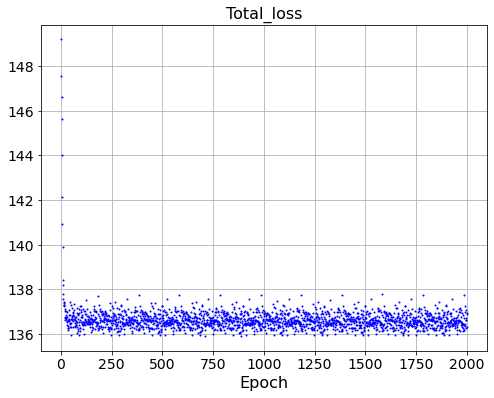

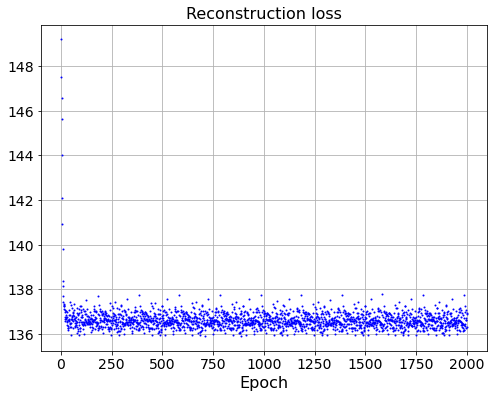

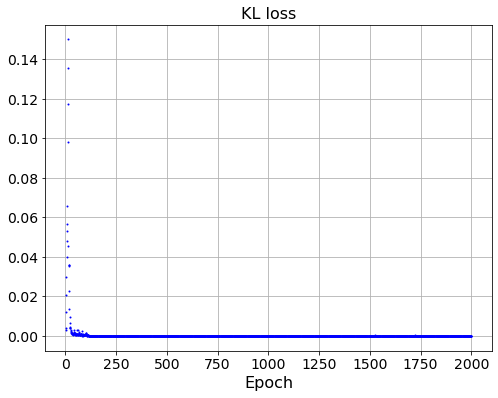

In [59]:
epochs = range(1, len(total_loss_all)+1)

plt.figure(figsize=(8,6))
plt.plot(epochs, total_loss_all, "b.", markersize=2, label="total_loss")
# plt.plot(epochs, val_acc, "r.", markersize=1, label="Validation accuracy")
plt.title("Total_loss",fontsize=16)
plt.xlabel('Epoch',fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid()
# plt.legend(fontsize=16)
plt.show()

plt.figure(figsize=(8,6))
plt.plot(epochs, reconstruction_loss_all, "b.", markersize=2, label="reconstruction_loss")
# plt.plot(epochs, val_loss, "r.", markersize=1, label="Validation loss")
plt.title("Reconstruction loss",fontsize=16)
plt.xlabel('Epoch',fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid()
# plt.legend(fontsize=16)
plt.show()

plt.figure(figsize=(8,6))
plt.plot(epochs, kl_loss_all, "b.", markersize=2, label="kl_loss")
# plt.plot(epochs, val_loss, "r.", markersize=1, label="Validation loss")
plt.title("KL loss",fontsize=16)
plt.xlabel('Epoch',fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid()
# plt.legend(fontsize=16)
plt.show()

In [29]:
# Saving of the trained vae
all_vae.encoder.save('all_encoder.tf',
        overwrite=True,include_optimizer=False,save_format='tf',
                 signatures=None,options=None)
all_vae.decoder.save('all_decoder.tf',
        overwrite=True,include_optimizer=False,save_format='tf',
                 signatures=None,options=None)

all_vae.encoder.save('all_encoder.h5',
        overwrite=True,include_optimizer=False,save_format='h5',
                 signatures=None,options=None)
all_vae.decoder.save('all_decoder.h5',
        overwrite=True,include_optimizer=False,save_format='h5',
                 signatures=None,options=None)

# Weight only saving
all_vae.encoder.save_weights('all_encoder_weights.h5', overwrite=True, 
                         save_format='h5', options=None)
all_vae.decoder.save_weights('all_decoder_weights.h5', overwrite=True, 
                         save_format='h5', options=None)

INFO:tensorflow:Assets written to: all_encoder.tf/assets
INFO:tensorflow:Assets written to: all_decoder.tf/assets


### Modeller environment: reference structure

In [30]:
# using MDAnalysis write out without hydrogens an input frame 
# from the 'protein' validation trajectory  

# The protein conformation in this frame will be the starting point,
# u_val.pdb, to apply the consecutive phi-psi angle changes when reconstructing
# a real space trajectory from a latent space trajectory.

input_protein_frame_number = -1

u_val.trajectory[input_protein_frame_number]
u_val_0_protein = u_val.select_atoms('protein and not (name H* )')

with mda.Writer("u_val.pdb",bonds='all',
                n_atoms=None,
                convert_units=True,
                reindex=True) as pdb:
    pdb.write(u_val_0_protein) 
    
u_val_0 = mda.Universe('u_val.pdb','u_val.pdb')

u_val_0_protein = u_val_0.select_atoms('protein and not (name H* )')

# Change chainid to 'A'
for atom_ind in range(len(u_val_0_protein)): 
    u_val_0.atoms[atom_ind].chainID = 'A'

n_res = len(u_val_0_protein.residues)

# If necessary, we shift all atoms into the unit cell
# u_val_0_protein.pack_into_box(box=None, inplace=True)

# Change HSD to HIS
HSD_ATOMS = u_val_0_protein.select_atoms('resname HSD')
for atom_ind in range(len(HSD_ATOMS)):
    HSD_ATOMS.atoms[atom_ind].residue.resname = 'HIS'
    
# Change Isoleucine CD to CD1
ILE_CD_ATOMS = u_val_0_protein.select_atoms('resname ILE and (name CD)')
for atom_ind in range(len(ILE_CD_ATOMS)):
    ILE_CD_ATOMS.atoms[atom_ind].name = 'CD1'

# Change CTERM atoms O1,O2 to O and OXT
lastresnum = 'resnum ' + str(len(u_val_0_protein.residues))
CTERM_ATOMS = u_val_0_protein.select_atoms(lastresnum)
CTERM_ATOMS[-2].name = 'O'
CTERM_ATOMS[-1].name = 'OXT'

with mda.Writer("u_val_0.pdb",bonds='all',
                n_atoms=None,
                convert_units=True,
                reindex=True) as pdb:
    pdb.write(u_val_0_protein)    

In [31]:
# After converting HSD to HIS, we write out the sequence in 1 letter code

# Protein sequence in 3 letter code
prot_sequence_tlc = ''
for res in chain.from_iterable(u_val_0_protein.residues.resnames):
    prot_sequence_tlc += res
# print(f'Protein sequence in 3 letter code:\n{prot_sequence_tlc}\n')

# Protein sequence as separated 3 letter code 
split_prot_sequence_tlc = []
n = 3
for index in range(0, len(prot_sequence_tlc), n):
    split_prot_sequence_tlc.append(prot_sequence_tlc[index : index + n])
# print(f'Protein sequence in split 3 letter code:\n{split_prot_sequence_tlc}\n')

# Protein sequence in 3 letter code
prot_sequence_slc = seq1(prot_sequence_tlc)
print(f'Protein sequence in 1 letter code:\n{prot_sequence_slc}')


Protein sequence in 1 letter code:
MRIILLGAPGAGKGTQAQFIMEKYGIPQISTGDMLRAAVKSGSELGKQAKDIMDAGKLVTDELVIALVKERIAQEDCRNGFLLDGFPRTIPQADAMKEAGINVDYVLEFDVPDELIVDRIVGRRVHAPSGRVYHVKFNPPKVEGKDDVTGEELTTRKDDQEETVRKRLVEYHQMTAPLIGYYSKEAEAGNTKYAKVDGTKPVAEVRADLEKILG


#### Modeller minimization of the reference structure

In [32]:
# Derive the basins vector of the validation frame selected. Then, 
# using the validation centroids convert the basins   
# into phi-psi angles in radians 
deg_to_rad = np.pi/180
u_val_0_basins = val_basins[input_protein_frame_number]
print(*u_val_0_basins)

u_val_0_phipsi_radians = []
for basin in u_val_0_basins:
    phi_psi = val_centroids[basin]*deg_to_rad
    u_val_0_phipsi_radians.append(phi_psi.tolist())
u_val_0_phipsi_radians = np.array(u_val_0_phipsi_radians)

0 0 0 0 0 3 0 1 2 1 1 0 2 1 1 1 1 1 1 1 1 1 1 2 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 2 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 3 0 0 0 0 2 0 0 1 0 1 1 1 1 1 1 1 1 1 1 2 1 0 0 1 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 2 0 0 0 0 1 1 1 0 0 0 1 0 0 2 0 0 1 1 1 2 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 0 0 0 0 0 0 0 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1


In [33]:
# Initial alignment
sequence = prot_sequence_slc + '*'

with open("alignment.ali", "w") as text_file:
    print(f'>P1;orig\nstructureX:u_val_0.pdb:1:A:{n_res}:A::::\n{sequence}',file=text_file)
    print(f'>P1;seq\nsequence::1:A:{n_res}:A::::\n{sequence}',file=text_file)
    

In [34]:
# Initial minimization of the reference structure with phi-psi constraints

log.level(output=0, notes=0, warnings=0, errors=0, memory=0)
env = Environ()
env.io.atom_files_directory = '.'
env.edat.dynamic_sphere = True

env.libs.topology.read(file='$(LIB)/top_heav.lib')
env.libs.parameters.read(file='$(LIB)/par.lib')

code = 'u_val_0'
mdl = complete_pdb(env, code + '.pdb')
rsr = mdl.restraints

# Select all atoms:
atmsel = Selection(mdl)    

# Generate the static restraints:
rsr.make(atmsel, restraint_type='stereo', spline_on_site=False)

# Example of atoms selection for phi-psi restraints
# 2 ARG PHI:  (1 MET C)-(2 ARG N)-(2 ARG CA)-(2 ARG C)  
# 2 ARG PSI:  (2 ARG N)-(2 ARG CA)-(2 ARG C)-(3 ILE N) 

# Add dynamic restraints on the phi-psi dihedrals
for i in range(2,214): 
    phi_1 = mdl.atoms['C:'+str(i-1)+':A']
    phi_2 = mdl.atoms['N:'+str(i)+':A']
    phi_3 = mdl.atoms['CA:'+str(i)+':A']
    phi_4 = mdl.atoms['C:'+str(i)+':A']    
    psi_1 = mdl.atoms['N:'+str(i)+':A']
    psi_2 = mdl.atoms['CA:'+str(i)+':A']
    psi_3 = mdl.atoms['C:'+str(i)+':A']
    psi_4 = mdl.atoms['N:'+str(i+1)+':A']

    # Binormal constraints
    rsr.add(forms.MultiBinormal(group=physical.phi_psi_dihedral,
                           features=[features.Dihedral(phi_1, phi_2, phi_3, phi_4),
                                     features.Dihedral(psi_1, psi_2, psi_3, psi_4)],
                           weights=[100,100],
                           means=[u_val_0_phipsi_radians[i-2,:].tolist(),                                
                                  u_val_0_phipsi_radians[i-2,:].tolist()],                                
                           stdevs=[[0.1,0.1],[0.1,0.1]],
                           correls=[0.5,0.5]))    

mdl.restraints.write(file = code + '.rsr')

# Addition of restraints to the default ones
class RestrainModel(AutoModel):
    def special_restraints(self, aln):
        rsr = self.restraints
        # Add restraints from file:
        rsr.append(file = code + '.rsr')          

a = RestrainModel(env,
            alnfile  = 'alignment.ali',     # alignment filename
            knowns   = 'orig',              # codes of the templates
            sequence = 'seq',
            )              # code of the target
a.starting_model= 1                 # index of the first model
a.ending_model  = 1                 # index of the last model
                                    # (determines how many models to calculate)
a.make()                            # do comparative modeling

a.write(file='u_val_0_min.pdb')


0 atoms in HETATM/BLK residues constrained
to protein atoms within 2.30 angstroms
and protein CA atoms within 10.00 angstroms
0 atoms in residues without defined topology
constrained to be rigid bodies

>> Summary of successfully produced models:
Filename                          molpdf
----------------------------------------
seq.B99990001.pdb             2476.93750



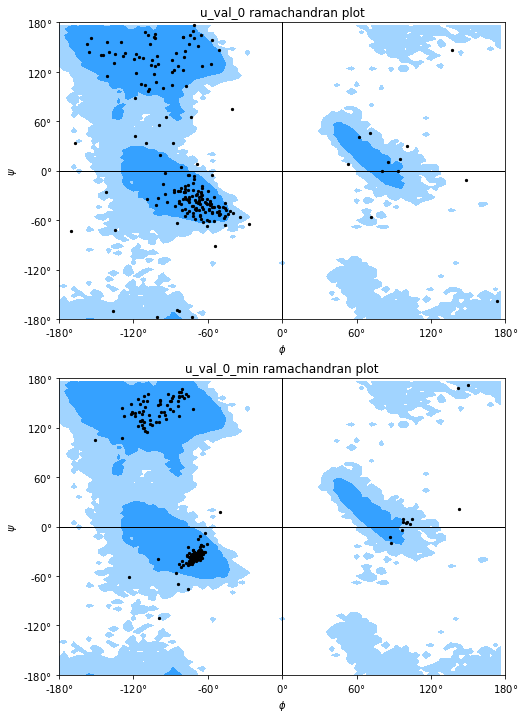

In [35]:
# Here we check that the phi=psi constraints really worked. After minimization 
# the ramachandran plot should show phi-psi angles clustered around the centroids
# To select a range of frames in a trajectory 
# use .run(startframe,endframe+1)

# Ramachandran angles in the reference protein. 
u_val_0 = mda.Universe('u_val_0.pdb','u_val_0.pdb')
u_val_0_protein = u_val_0.select_atoms('protein and not (name H* )')
u_val_0_rama = dihedrals.Ramachandran(u_val_0_protein).run()
plt.figure(figsize=(8, 12)) 
plt.subplot(2,1,1)
u_val_0_rama.plot(color='black', marker='.', s=20, ref=True)
plt.title('u_val_0 ramachandran plot') 
u_val_0_phipsi_obs_radians = u_val_0_rama.results.angles * deg_to_rad
# print(f'Ramachandran angles array shape: {u_val_0_phipsi.shape}')
# print(u_val_0_phipsi_radians.shape)
# print(u_val_0_phipsi_radians[0][:6])

# Ramachandran angles in the minimized reference protein. 
u_val_0_min = mda.Universe('u_val_0_min.pdb','u_val_0_min.pdb')
u_val_0_min_protein = u_val_0_min.select_atoms('protein and not (name H* )')
u_val_0_min_rama = dihedrals.Ramachandran(u_val_0_min_protein).run()
plt.subplot(2,1,2)
u_val_0_min_rama.plot(color='black', marker='.', s=20, ref=True)
plt.title('u_val_0_min ramachandran plot')          
u_val_0_min_phipsi_radians = u_val_0_min_rama.results.angles * deg_to_rad
# print(f'Ramachandran angles array shape: {u_val_0_min_phipsi.shape}')
# print(u_val_0_min_phipsi_radians.shape)
# print(u_val_0_min_phipsi_radians[0][:6])

#### Function to generate real space phi-psi trajectory from latent space trajectory

In [36]:
# Convert basin trajectory into angle trajectory using centroids
def single_frame_phipsi_radians_from_basins(basins,centroids):

    deg_to_rad = np.pi/180.
    single_frame_phi_psi = []
    for j,basin in enumerate(basins):
        if basin>3:
            print(i,j,basin)
            # print(*frame)
            break

        phi_psi = centroids[basin]*deg_to_rad
        single_frame_phi_psi.append(phi_psi.tolist())
        single_frame_phi_psi_ndarray = np.array(single_frame_phi_psi)

    return single_frame_phi_psi_ndarray


def gen_trj_from_latent_space(active_vae,n_conf,grid_x,grid_y,digit_size,centroids):

    vae_list = []
    # phi_psi_radians_list = []
    for i_conf in range(n_conf):
        z_sample = np.array([[grid_x[i_conf], grid_y[i_conf]]])
        print(z_sample)
        x_decoded = active_vae.decoder.predict(z_sample)
        x_decoded = x_decoded[0][2:-2].reshape(digit_size)
        x_decoded *= 4
        x_decoded -= 1
        x_decoded = np.rint(x_decoded).astype('int32')
        phipsi_radians = single_frame_phipsi_radians_from_basins(x_decoded,centroids)
        # phi_psi_radians_list.append(phipsi_radians)

        # Modeller environment
        log.level(output=0, notes=0, warnings=0, errors=0, memory=0)
        env = Environ()
        env.io.atom_files_directory = '.'
        env.edat.dynamic_sphere = True

        env.libs.topology.read(file='$(LIB)/top_heav.lib')
        env.libs.parameters.read(file='$(LIB)/par.lib')
        
        if i_conf == 0:
            # here we choose the minimized structure selected for extension
            code = 'u_val_0_min'                
        else:
            # here we choose the previous extended frame as the start frame 
            code = 'u_basin_VAE_min_' + str(i_conf-1)
            
        ali_code = code + '.pdb'
        with open("alignment_min.ali", "w") as text_file:
            print(f'>P1;orig\nstructureX:{ali_code}:1:A:{n_res}:A::::\n{sequence}',file=text_file)
            print(f'>P1;seq\nsequence::1:A:{n_res}:A::::\n{sequence}',file=text_file)            

        mdl = complete_pdb(env, code + '.pdb')

        # Select all atoms:
        atmsel = Selection(mdl)       

        rsr = mdl.restraints   

        # Generate static restraints:
        rsr.make(atmsel, restraint_type='stereo', spline_on_site=False)

        # Example of phi and phi angles atoms definition
        # 2 ARG PHI:  (1 MET C)-(2 ARG N)-(2 ARG CA)-(2 ARG C)  
        # 2 ARG PSI:  (2 ARG N)-(2 ARG CA)-(2 ARG C)-(3 ILE N) 

        # Add dynamic restraints on the phi-psi dihedrals
        for i in range(2,digit_size+2): 
            phi_1 = mdl.atoms['C:'+str(i-1)+':A']
            phi_2 = mdl.atoms['N:'+str(i)+':A']
            phi_3 = mdl.atoms['CA:'+str(i)+':A']
            phi_4 = mdl.atoms['C:'+str(i)+':A']    
            psi_1 = mdl.atoms['N:'+str(i)+':A']
            psi_2 = mdl.atoms['CA:'+str(i)+':A']
            psi_3 = mdl.atoms['C:'+str(i)+':A']
            psi_4 = mdl.atoms['N:'+str(i+1)+':A']

            # Binormal constraints
            rsr.add(forms.MultiBinormal(group=physical.phi_psi_dihedral,
                                   features=[features.Dihedral(phi_1, phi_2, phi_3, phi_4),
                                             features.Dihedral(psi_1, psi_2, psi_3, psi_4)],
                                   weights=[100,100],
                                   means=[phipsi_radians[i-2,:].tolist(),
                                          phipsi_radians[i-2,:].tolist()],
                                   stdevs=[[0.1,0.1],[0.1,0.1]],
                                   correls=[0.5,0.5]))    

        mdl.restraints.write(file = code + '.rsr')

        # Addition of restraints to the default ones
        class RestrainModel(AutoModel):
            def special_restraints(self, aln):
                rsr = self.restraints
                # Add restraints from file:
                rsr.append(file = code + '.rsr')          

        a = RestrainModel(env,
                    alnfile  = 'alignment_min.ali',     # alignment filename
                    knowns   = 'orig',              # codes of the templates
                    sequence = 'seq',
                    )              # code of the target
        a.starting_model= 1                 # index of the first model
        a.ending_model  = 1                 # index of the last model
                                            # (determines how many models to calculate)
        a.make()                            # do comparative modeling

        a.write(file='u_basin_VAE_min_'+str(i_conf)+'.pdb')

        vae_list.append('u_basin_VAE_min_'+str(i_conf)+'.pdb')

    return vae_list


### Latent space pdf representation

In [37]:
keras.backend.clear_session()
if 'encoder' in globals():
    del encoder
if 'decoder' in globals():
    del decoder
if 'active_vae' in globals():    
    del active_vae
       
# load encoder and decoder 
# encoder = keras.models.load_model("val_encoder.tf")
# decoder = keras.models.load_model("val_decoder.tf")

encoder = keras.models.load_model("all_encoder.tf")
decoder = keras.models.load_model("all_decoder.tf")

active_vae = VAE(encoder,decoder)
active_vae.compile(optimizer=keras.optimizers.Adam(), run_eagerly=True)

active_dataset = all_dataset
n_sample = 20
centroids = all_centroids

In [38]:
# encoder reconstruction of the training set latent space 
z_mean, z_log_var = active_vae.encoder.predict(active_dataset) 
z_shape = z_mean.shape
print(z_shape)


z_mat_0 = []
z_mat_1 = []
for i in range(n_sample):
    z = Sampler()(z_mean,z_log_var).numpy()
    # print(f'z_shape: {z.shape}')
    z_mat_0.append(z[:,0])
    z_mat_1.append(z[:,1])

z_mat_0 = np.array(z_mat_0).reshape(-1)
z_mat_1 = np.array(z_mat_1).reshape(-1)
print(z_mat_0.shape)
print(z_mat_1.shape)
z_mat_0_range = (np.min(z_mat_0),np.max(z_mat_0))
z_mat_1_range = (np.min(z_mat_1),np.max(z_mat_1))
z_mat_0_var = (np.var(z_mat_0))
z_mat_1_var = (np.var(z_mat_1))
print(z_mat_0_range,z_mat_0_var)
print(z_mat_1_range,z_mat_1_var)



(18036, 2)
(360720,)
(360720,)
(-4.937527, 4.217793) 0.99712604
(-4.9515176, 4.306206) 1.0016137


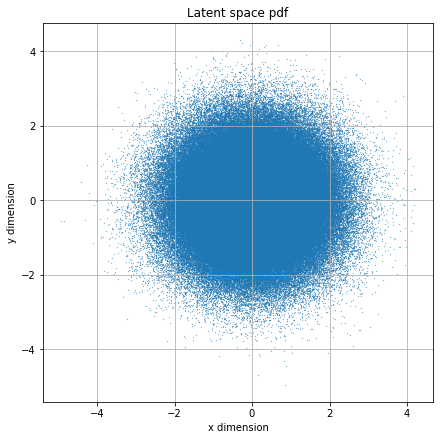

In [39]:
# plotting of the training trajectory in latent space. Notice that each time we 
# retrain the network, the trajectory in latent space may look very different 
# because of the initial random assignment of weights in the VAE network.
fig, ax1 = plt.subplots(1, 1, constrained_layout=True,figsize=(6,6))
ax1.scatter(z_mat_0,z_mat_1,s=0.05)
ax1.grid()

# add figure labels and titles
ax1.set_ylabel('y dimension')
ax1.set_xlabel('x dimension')
ax1.set_title('Latent space pdf')
plt.show()


#### Extent of the useful latent space

In [40]:
min_x = np.min(z_mat_0)*1.1
max_x = np.max(z_mat_0)*1.1
mean_x = np.mean(z_mat_0)
min_y = np.min(z_mat_1)*1.1
max_y = np.max(z_mat_1)*1.1
mean_y = np.mean(z_mat_1)
print(min_x,mean_x,max_x)
print(min_y,mean_y,max_y)

-5.431279897689819 -0.0019456157 4.639572286605835
-5.446669340133667 0.002373924 4.736826848983765


#### View a trajectory through latent space: example 1

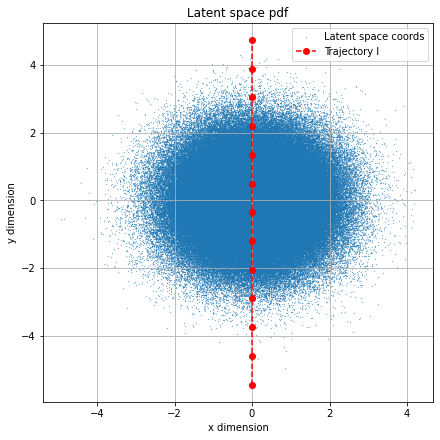

In [41]:
# Build the trajectory
n_conf = 13
n_basins = 212

# Trajectory I
grid_x = np.ones((n_conf))*np.mean(z_mat_0)
grid_y = np.linspace(min_y, max_y, n_conf)

# plotting
fig,ax1 = plt.subplots(1, 1, constrained_layout=True,figsize=(6,6))
pdf = ax1.scatter(z_mat_0,z_mat_1,s=0.05)
trj, = ax1.plot(grid_x,grid_y,'--or')
ax1.grid()

# add figure labels and titles
ax1.set_ylabel('y dimension')
ax1.set_xlabel('x dimension')
ax1.legend([pdf,trj],['Latent space coords','Trajectory I'])
ax1.set_title('Latent space pdf')
plt.show()

In [42]:
# generate real space trajectory
vae_list = gen_trj_from_latent_space(active_vae,
                                     n_conf,
                                     grid_x,
                                     grid_y,
                                     n_basins,
                                     centroids)


[[-1.94561575e-03 -5.44666934e+00]]
0 atoms in HETATM/BLK residues constrained
to protein atoms within 2.30 angstroms
and protein CA atoms within 10.00 angstroms
0 atoms in residues without defined topology
constrained to be rigid bodies

>> Summary of successfully produced models:
Filename                          molpdf
----------------------------------------
seq.B99990001.pdb             2487.94995

[[-1.94561575e-03 -4.59804466e+00]]
0 atoms in HETATM/BLK residues constrained
to protein atoms within 2.30 angstroms
and protein CA atoms within 10.00 angstroms
0 atoms in residues without defined topology
constrained to be rigid bodies

>> Summary of successfully produced models:
Filename                          molpdf
----------------------------------------
seq.B99990001.pdb             1977.98242

[[-1.94561575e-03 -3.74941998e+00]]
0 atoms in HETATM/BLK residues constrained
to protein atoms within 2.30 angstroms
and protein CA atoms within 10.00 angstroms
0 atoms in residues with

In [43]:
# Check extended list
vae_list = vae_list[:n_conf]
print(vae_list)

# If reverse is True the displayed trj will go back and forth
reverse = True

if reverse:
    vae_list.append(vae_list[::-1])

# ife tag as input_frame_early    
real_space_trj_ex1 = mda.Universe('u_val_0_min.pdb',vae_list)

# Fit in place extended trj to the reference structure
alignment_ex1 = align.AlignTraj(real_space_trj_ex1, u_val_0_min, in_memory=True)
alignment_ex1.run()

view_real_space_trj_ex1 = nv.show_mdanalysis(real_space_trj_ex1)

view_real_space_trj_ex1.center()
view_real_space_trj_ex1


['u_basin_VAE_min_0.pdb', 'u_basin_VAE_min_1.pdb', 'u_basin_VAE_min_2.pdb', 'u_basin_VAE_min_3.pdb', 'u_basin_VAE_min_4.pdb', 'u_basin_VAE_min_5.pdb', 'u_basin_VAE_min_6.pdb', 'u_basin_VAE_min_7.pdb', 'u_basin_VAE_min_8.pdb', 'u_basin_VAE_min_9.pdb', 'u_basin_VAE_min_10.pdb', 'u_basin_VAE_min_11.pdb', 'u_basin_VAE_min_12.pdb']


NGLWidget(max_frame=25)

#### View a trajectory through latent space: example 2

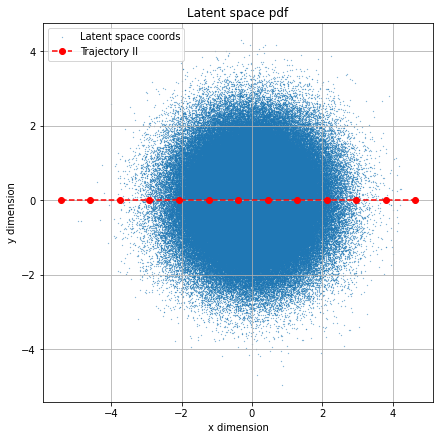

In [44]:
# Build the trajectory
n_conf = 13
n_basins = 212

# Trajectory II
grid_x = np.linspace(min_x, max_x, n_conf)
grid_y = np.ones((n_conf))*np.mean(z_mat_0)

# plotting
fig,ax1 = plt.subplots(1, 1, constrained_layout=True,figsize=(6,6))
pdf = ax1.scatter(z_mat_0,z_mat_1,s=0.05)
trj, = ax1.plot(grid_x,grid_y,'--or')
ax1.grid()

# add figure labels and titles
ax1.set_ylabel('y dimension')
ax1.set_xlabel('x dimension')
ax1.legend([pdf,trj],['Latent space coords','Trajectory II'])
ax1.set_title('Latent space pdf')
plt.show()

In [45]:
# generate real space trajectory
vae_list = gen_trj_from_latent_space(active_vae,
                                     n_conf,
                                     grid_x,
                                     grid_y,
                                     n_basins,
                                     centroids)


[[-5.43127990e+00 -1.94561575e-03]]
0 atoms in HETATM/BLK residues constrained
to protein atoms within 2.30 angstroms
and protein CA atoms within 10.00 angstroms
0 atoms in residues without defined topology
constrained to be rigid bodies

>> Summary of successfully produced models:
Filename                          molpdf
----------------------------------------
seq.B99990001.pdb             2487.94995

[[-4.59204222e+00 -1.94561575e-03]]
0 atoms in HETATM/BLK residues constrained
to protein atoms within 2.30 angstroms
and protein CA atoms within 10.00 angstroms
0 atoms in residues without defined topology
constrained to be rigid bodies

>> Summary of successfully produced models:
Filename                          molpdf
----------------------------------------
seq.B99990001.pdb             1977.98242

[[-3.75280453e+00 -1.94561575e-03]]
0 atoms in HETATM/BLK residues constrained
to protein atoms within 2.30 angstroms
and protein CA atoms within 10.00 angstroms
0 atoms in residues with

In [46]:
# Check extended list
vae_list = vae_list[:n_conf]
print(vae_list)

# If reverse is True the displayed trj will go back and forth
reverse = True

if reverse:
    vae_list.append(vae_list[::-1])

# ife tag as input_frame_early    
real_space_trj_ex2 = mda.Universe('u_val_0_min.pdb',vae_list)

# Fit in place extended trj to the reference structure
alignment_ex2 = align.AlignTraj(real_space_trj_ex2, u_val_0_min, in_memory=True)
alignment_ex2.run()

view_real_space_trj_ex2 = nv.show_mdanalysis(real_space_trj_ex2)

view_real_space_trj_ex2.center()
view_real_space_trj_ex2


['u_basin_VAE_min_0.pdb', 'u_basin_VAE_min_1.pdb', 'u_basin_VAE_min_2.pdb', 'u_basin_VAE_min_3.pdb', 'u_basin_VAE_min_4.pdb', 'u_basin_VAE_min_5.pdb', 'u_basin_VAE_min_6.pdb', 'u_basin_VAE_min_7.pdb', 'u_basin_VAE_min_8.pdb', 'u_basin_VAE_min_9.pdb', 'u_basin_VAE_min_10.pdb', 'u_basin_VAE_min_11.pdb', 'u_basin_VAE_min_12.pdb']


NGLWidget(max_frame=25)

### View a trajectory through latent space: example 3

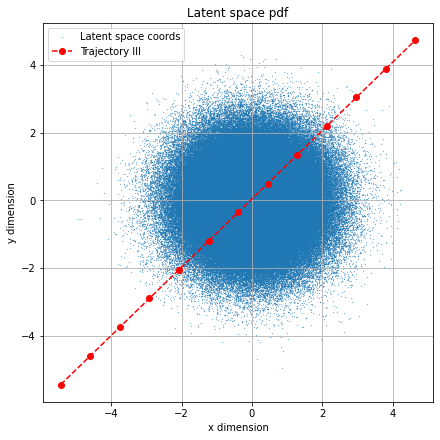

In [47]:
# Build the trajectory
n_conf = 13
n_basins = 212

# Trajectory III
grid_x = np.linspace(min_x, max_x, n_conf)
grid_y = np.linspace(min_y, max_y, n_conf)

# plotting
fig,ax1 = plt.subplots(1, 1, constrained_layout=True,figsize=(6,6))
pdf = ax1.scatter(z_mat_0,z_mat_1,s=0.05)
trj, = ax1.plot(grid_x,grid_y,'--or')
ax1.grid()

# add figure labels and titles
ax1.set_ylabel('y dimension')
ax1.set_xlabel('x dimension')
ax1.legend([pdf,trj],['Latent space coords','Trajectory III'])
ax1.set_title('Latent space pdf')
plt.show()

In [48]:
# generate real space trajectory
vae_list = gen_trj_from_latent_space(active_vae,
                                     n_conf,
                                     grid_x,
                                     grid_y,
                                     n_basins,
                                     centroids)


[[-5.4312799  -5.44666934]]
0 atoms in HETATM/BLK residues constrained
to protein atoms within 2.30 angstroms
and protein CA atoms within 10.00 angstroms
0 atoms in residues without defined topology
constrained to be rigid bodies

>> Summary of successfully produced models:
Filename                          molpdf
----------------------------------------
seq.B99990001.pdb             2487.94995

[[-4.59204222 -4.59804466]]
0 atoms in HETATM/BLK residues constrained
to protein atoms within 2.30 angstroms
and protein CA atoms within 10.00 angstroms
0 atoms in residues without defined topology
constrained to be rigid bodies

>> Summary of successfully produced models:
Filename                          molpdf
----------------------------------------
seq.B99990001.pdb             1977.98242

[[-3.75280453 -3.74941998]]
0 atoms in HETATM/BLK residues constrained
to protein atoms within 2.30 angstroms
and protein CA atoms within 10.00 angstroms
0 atoms in residues without defined topology
con

In [49]:
# Check extended list
vae_list = vae_list[:n_conf]
print(vae_list)

# If reverse is True the displayed trj will go back and forth
reverse = True

if reverse:
    vae_list.append(vae_list[::-1])

# ife tag as input_frame_early    
real_space_trj_ex3 = mda.Universe('u_val_0_min.pdb',vae_list)

# Fit in place extended trj to the reference structure
alignment_ex3 = align.AlignTraj(real_space_trj_ex3, u_val_0_min, in_memory=True)
alignment_ex3.run()

view_real_space_trj_ex3 = nv.show_mdanalysis(real_space_trj_ex3)

view_real_space_trj_ex3.center()
view_real_space_trj_ex3


['u_basin_VAE_min_0.pdb', 'u_basin_VAE_min_1.pdb', 'u_basin_VAE_min_2.pdb', 'u_basin_VAE_min_3.pdb', 'u_basin_VAE_min_4.pdb', 'u_basin_VAE_min_5.pdb', 'u_basin_VAE_min_6.pdb', 'u_basin_VAE_min_7.pdb', 'u_basin_VAE_min_8.pdb', 'u_basin_VAE_min_9.pdb', 'u_basin_VAE_min_10.pdb', 'u_basin_VAE_min_11.pdb', 'u_basin_VAE_min_12.pdb']


NGLWidget(max_frame=25)

### View a trajectory through latent space: example 4

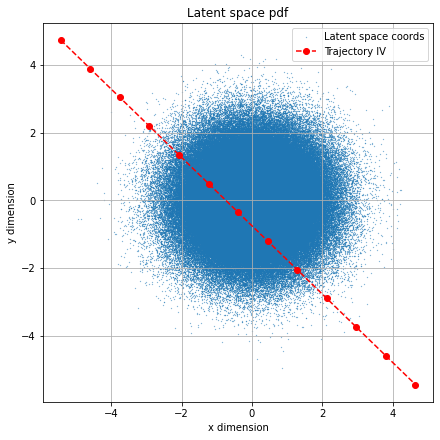

In [50]:
# Build the trajectory
n_conf = 13
n_basins = 212

# Trajectory III
grid_x = np.linspace(min_x, max_x, n_conf)
grid_y = np.linspace(min_y, max_y, n_conf)[::-1]

# plotting
fig,ax1 = plt.subplots(1, 1, constrained_layout=True,figsize=(6,6))
pdf = ax1.scatter(z_mat_0,z_mat_1,s=0.05)
trj, = ax1.plot(grid_x,grid_y,'--or')
ax1.grid()

# add figure labels and titles
ax1.set_ylabel('y dimension')
ax1.set_xlabel('x dimension')
ax1.legend([pdf,trj],['Latent space coords','Trajectory IV'])
ax1.set_title('Latent space pdf')
plt.show()

In [51]:
# generate real space trajectory
vae_list = gen_trj_from_latent_space(active_vae,
                                     n_conf,
                                     grid_x,
                                     grid_y,
                                     n_basins,
                                     centroids)


[[-5.4312799   4.73682685]]
0 atoms in HETATM/BLK residues constrained
to protein atoms within 2.30 angstroms
and protein CA atoms within 10.00 angstroms
0 atoms in residues without defined topology
constrained to be rigid bodies

>> Summary of successfully produced models:
Filename                          molpdf
----------------------------------------
seq.B99990001.pdb             2487.94995

[[-4.59204222  3.88820217]]
0 atoms in HETATM/BLK residues constrained
to protein atoms within 2.30 angstroms
and protein CA atoms within 10.00 angstroms
0 atoms in residues without defined topology
constrained to be rigid bodies

>> Summary of successfully produced models:
Filename                          molpdf
----------------------------------------
seq.B99990001.pdb             1977.98242

[[-3.75280453  3.03957748]]
0 atoms in HETATM/BLK residues constrained
to protein atoms within 2.30 angstroms
and protein CA atoms within 10.00 angstroms
0 atoms in residues without defined topology
con

In [52]:
# Check extended list
vae_list = vae_list[:n_conf]
print(vae_list)

# If reverse is True the displayed trj will go back and forth
reverse = True

if reverse:
    vae_list.append(vae_list[::-1])

# ife tag as input_frame_early    
real_space_trj_ex4 = mda.Universe('u_val_0_min.pdb',vae_list)

# Fit in place extended trj to the reference structure
alignment_ex4 = align.AlignTraj(real_space_trj_ex4, u_val_0_min, in_memory=True)
alignment_ex4.run()

view_real_space_trj_ex4 = nv.show_mdanalysis(real_space_trj_ex4)

view_real_space_trj_ex4.center()
view_real_space_trj_ex4


['u_basin_VAE_min_0.pdb', 'u_basin_VAE_min_1.pdb', 'u_basin_VAE_min_2.pdb', 'u_basin_VAE_min_3.pdb', 'u_basin_VAE_min_4.pdb', 'u_basin_VAE_min_5.pdb', 'u_basin_VAE_min_6.pdb', 'u_basin_VAE_min_7.pdb', 'u_basin_VAE_min_8.pdb', 'u_basin_VAE_min_9.pdb', 'u_basin_VAE_min_10.pdb', 'u_basin_VAE_min_11.pdb', 'u_basin_VAE_min_12.pdb']


NGLWidget(max_frame=25)